# Bathymetry and RMSE analysis
---
A reviewer suggested to analyze the relationship between the bathymetry and the RMSE of the SST temperature:

> 1. The study did not thoroughly analyze the impact of terrain heterogeneity (such as differences in nearshore slope and upwelling intensity) between the Canary Islands and the Northwest African coast on the performance of water depth sensing grids, making it difficult to clarify the grid adaptation rules under terrain differences. It is recommended to supplement this dimension for comparative analysis to enhance the specificity of the results.


## Experiment 1: k connectivity and bathymetry
---

In [12]:
# First-party imports
import sys, os
import numpy as np
import warnings
sys.path.append(os.path.expanduser('~/Seacast'))
from src.seacast_tools.scoring_analysis import *
# Set up session settings
warnings.filterwarnings('ignore', category=FutureWarning)

In [13]:
experiments_names = [
    'bathymetry_m_14_6_g2mm2g_1',
    'bathymetry_m_14_6_g2mm2g_2',
    'bathymetry_m_14_6_g2mm2g_3',
    'bathymetry_m_14_6_g2mm2g_4',
    'bathymetry_m_14_6_g2mm2g_5',
    'bathymetry_m_14_6_g2mm2g_6',
    ]

experiments = [StatsLoader(os.path.join("~/Seacast/output/exps_g2m", exp_name)) for exp_name in experiments_names]
experiments

[ExpStats(name=bathymetry_m_14_6_g2mm2g_1, stats_dir=/home/giovanny/Seacast/output/exps_g2m/bathymetry_m_14_6_g2mm2g_1/statistics),
 ExpStats(name=bathymetry_m_14_6_g2mm2g_2, stats_dir=/home/giovanny/Seacast/output/exps_g2m/bathymetry_m_14_6_g2mm2g_2/statistics),
 ExpStats(name=bathymetry_m_14_6_g2mm2g_3, stats_dir=/home/giovanny/Seacast/output/exps_g2m/bathymetry_m_14_6_g2mm2g_3/statistics),
 ExpStats(name=bathymetry_m_14_6_g2mm2g_4, stats_dir=/home/giovanny/Seacast/output/exps_g2m/bathymetry_m_14_6_g2mm2g_4/statistics),
 ExpStats(name=bathymetry_m_14_6_g2mm2g_5, stats_dir=/home/giovanny/Seacast/output/exps_g2m/bathymetry_m_14_6_g2mm2g_5/statistics),
 ExpStats(name=bathymetry_m_14_6_g2mm2g_6, stats_dir=/home/giovanny/Seacast/output/exps_g2m/bathymetry_m_14_6_g2mm2g_6/statistics)]

In [14]:
%%time
# Load score stats
for exp in experiments[2:3]:
    print(exp)
    with StatsAggSession(exp) as stats:
        lead_time_scores = stats.agg_scores(
            ['init_time']
            )

Experiment: bathymetry_m_14_6_g2mm2g_3, Statistics Directory: /home/giovanny/Seacast/output/exps_g2m/bathymetry_m_14_6_g2mm2g_3/statistics
CPU times: user 10.7 s, sys: 9.4 s, total: 20.1 s
Wall time: 20.1 s


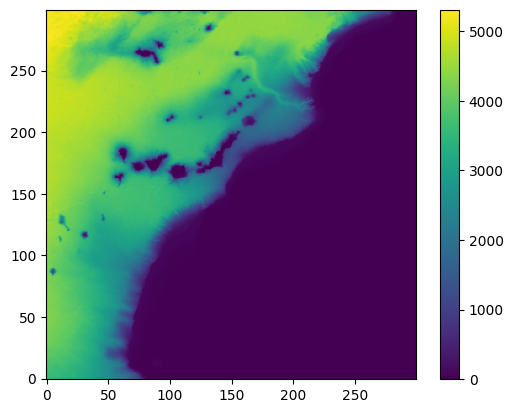

In [15]:
# Load npy file
bathy = np.load('/home/giovanny/Seacast/data/atlantic/static/sea_depth.npy')
plt.imshow(bathy, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

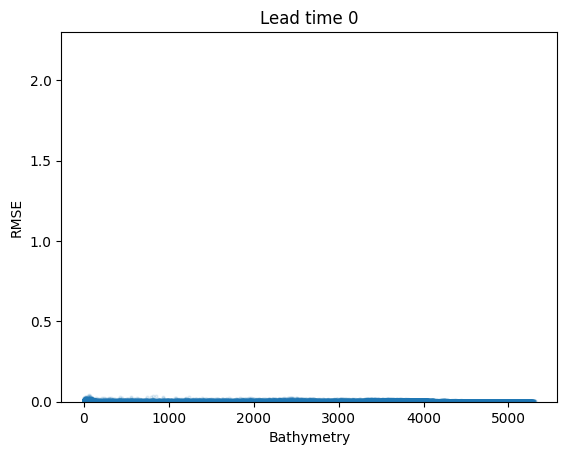

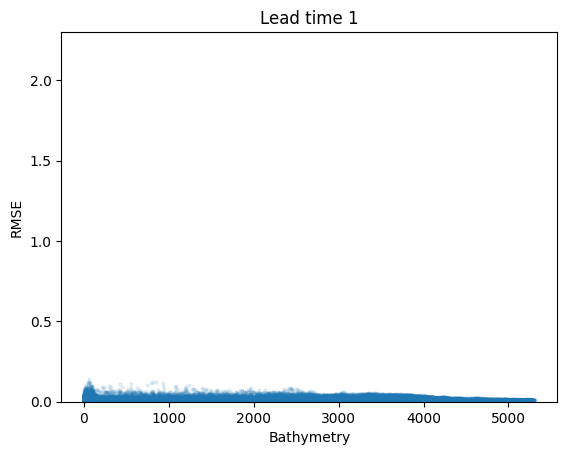

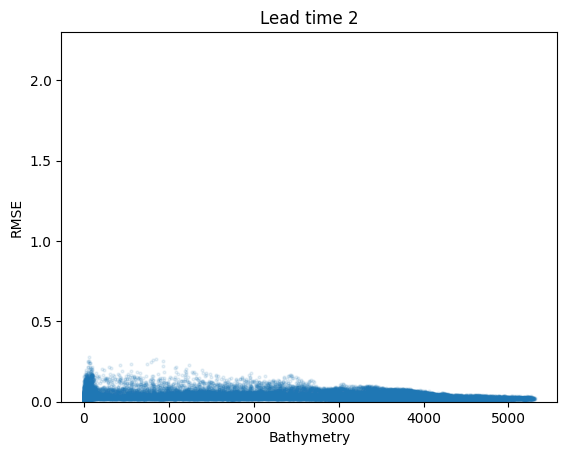

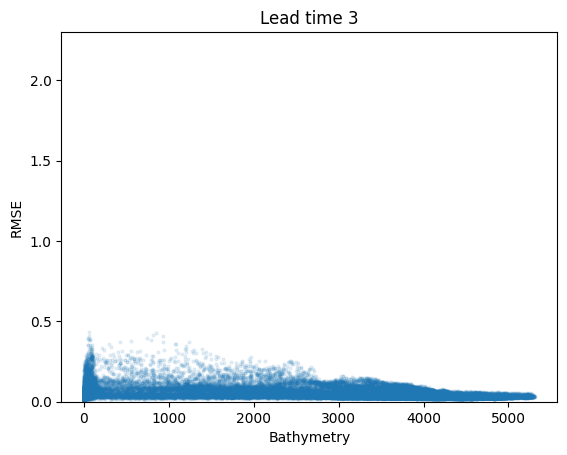

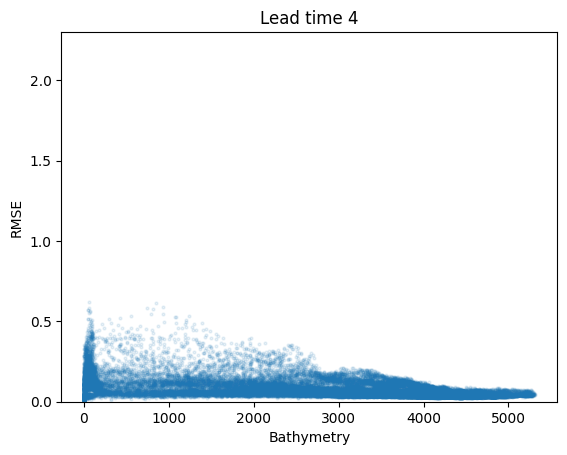

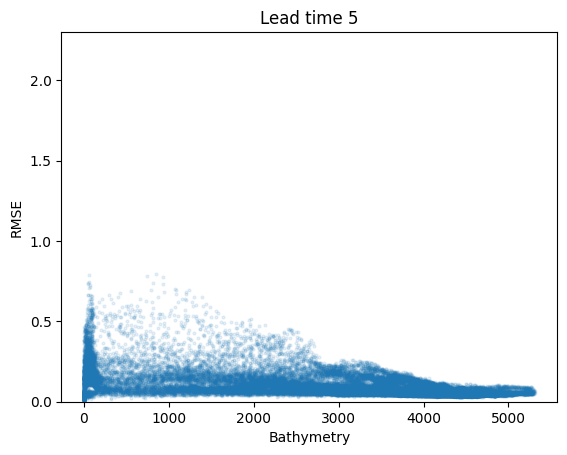

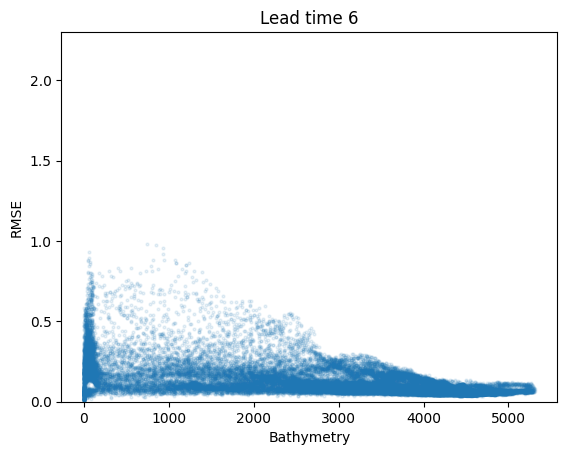

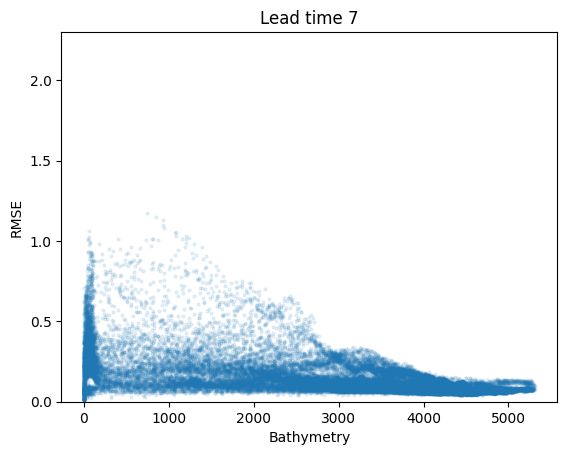

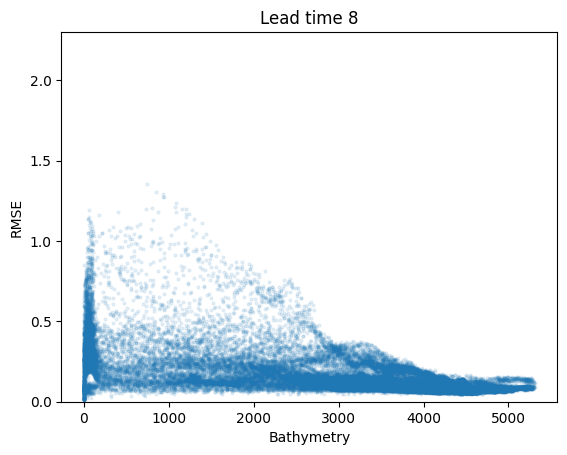

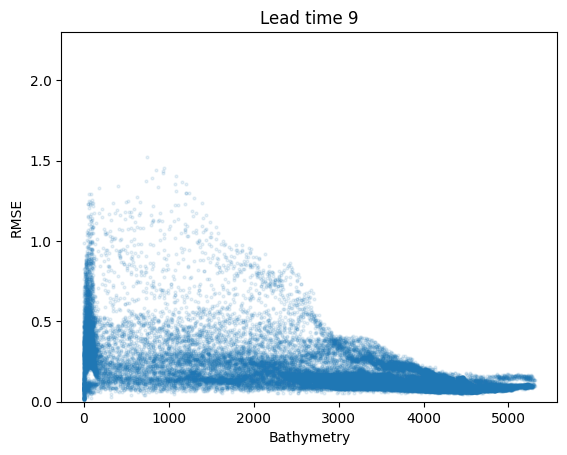

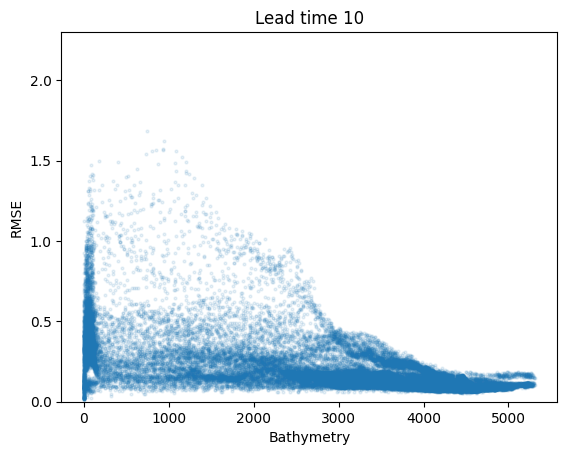

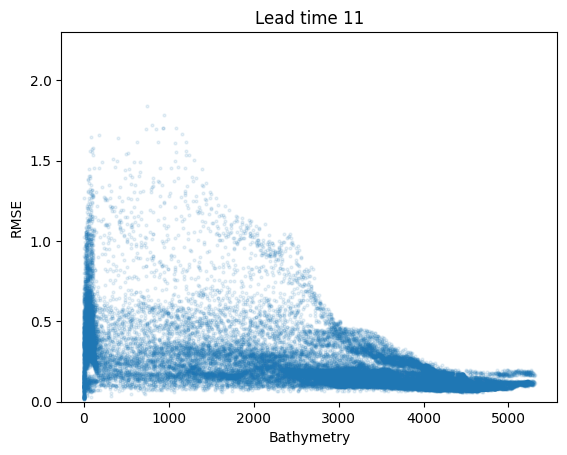

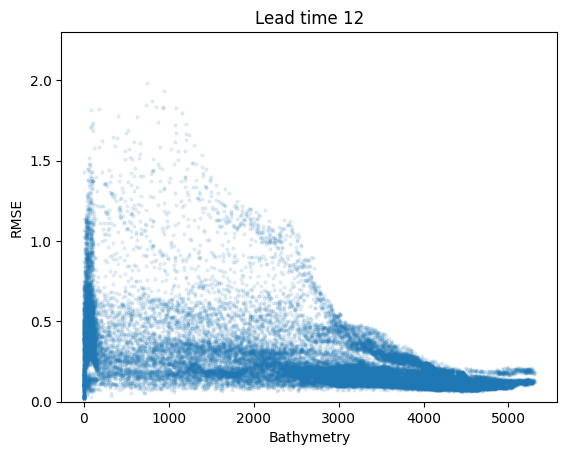

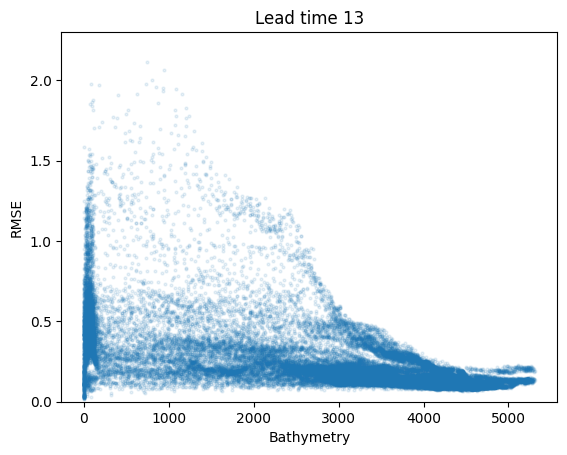

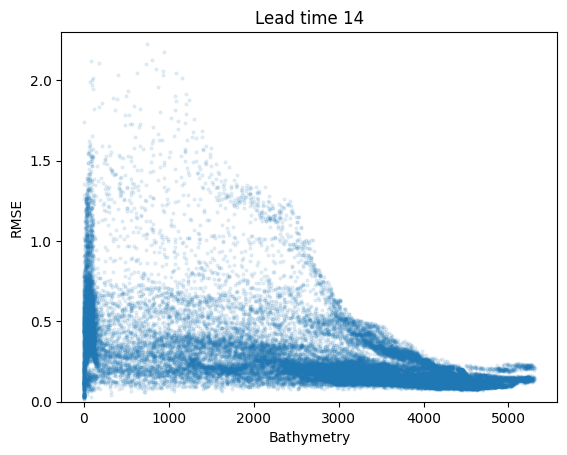

In [16]:
lead_time = 0
for lead_time in range(0, 15):
    rmse = lead_time_scores['SquaredError']['sst_temperature'].isel(lead_time=lead_time).data
    plt.scatter(bathy.flatten(), rmse.flatten(), alpha=0.1, s=4)
    plt.xlabel('Bathymetry')
    plt.ylabel('RMSE')
    plt.ylim(0, 2.3)
    plt.title(f'Lead time {lead_time}')
    plt.show()

In [17]:
# Define a function to get binned rmse data by a given array in this case bathymetry
def get_binned_rmse_by_array(
    rmse_da: xr.DataArray, 
    array: np.ndarray, 
    bin_type: str
    ) -> xr.core.groupby.DataArrayGroupBy:
    """
    Function to get binned rmse data by a given array in this case bathymetry
    """
    # Convertir la matriz numpy de batimetría en un DataArray de Xarray
    array_da = xr.DataArray(
        array,
        dims=['latitude', 'longitude'],
        name='bathymetry'
    )

    # Añadir la batimetría al DataArray de RMSE como una coordenada
    rmse_da['bathymetry'] = array_da

    bins = (
        np.logspace(array.min(), np.log10(array.max()), 18) # Log bins
        if bin_type == 'log' 
        else np.linspace(array.min(), array.max(), 18) # Linear bins
    )

    # Aplicar groupby_bins() y calcular la media del RMSE para cada bin de batimetría
    return rmse_da.groupby_bins(
        'bathymetry',  # La coordenada o variable para agrupar
        bins,          # Los límites de los bins
        right=True     # Indica si los bins incluyen el borde derecho (ej: (a, b])
        )
    

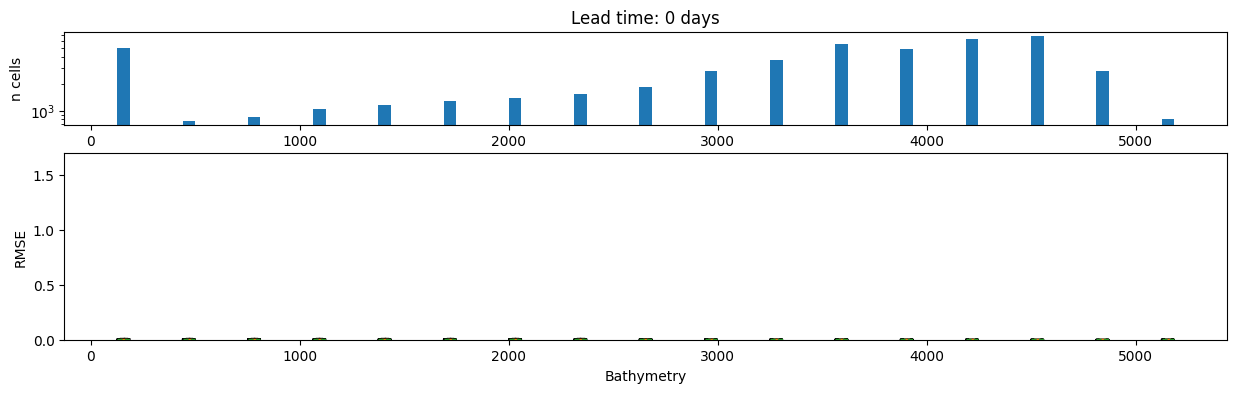

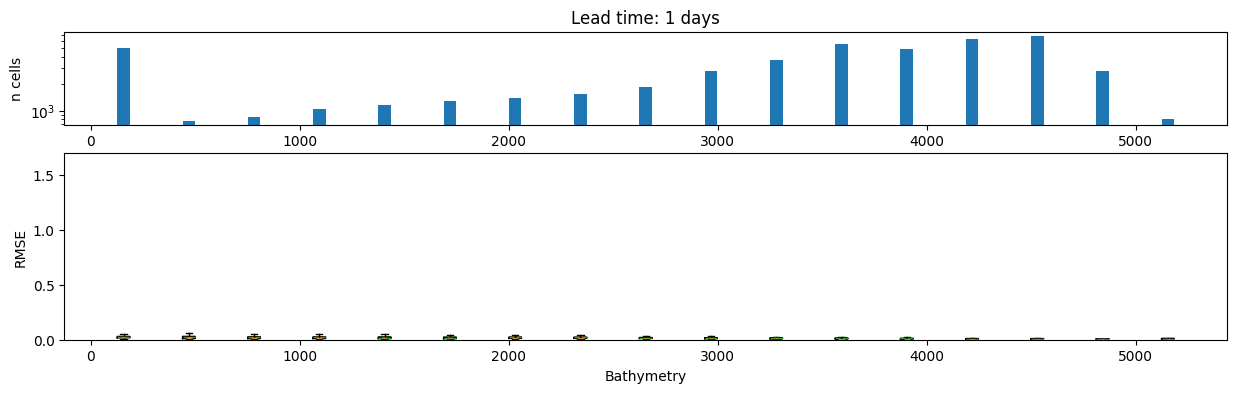

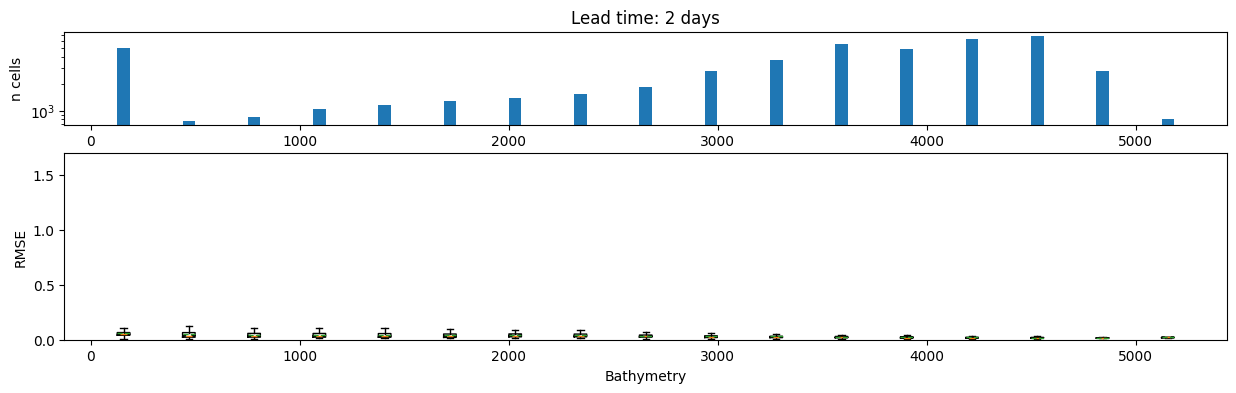

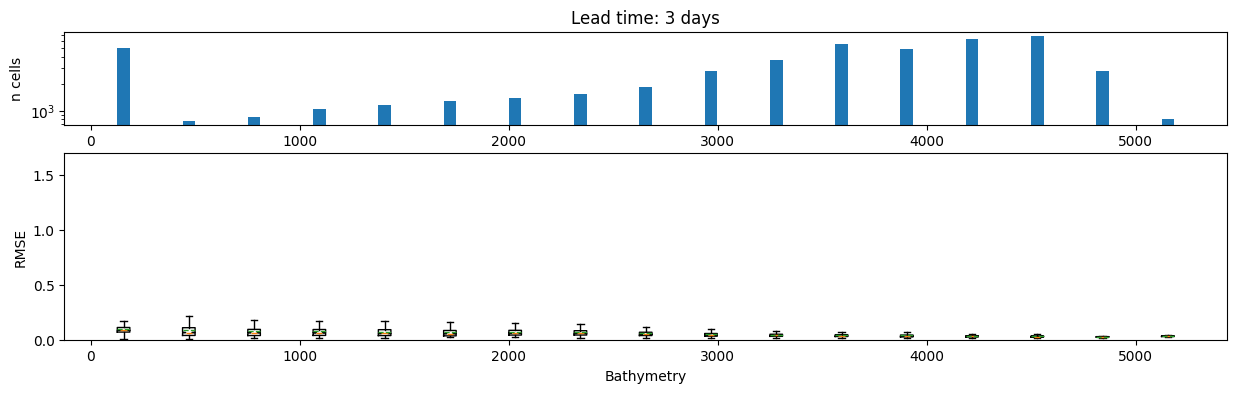

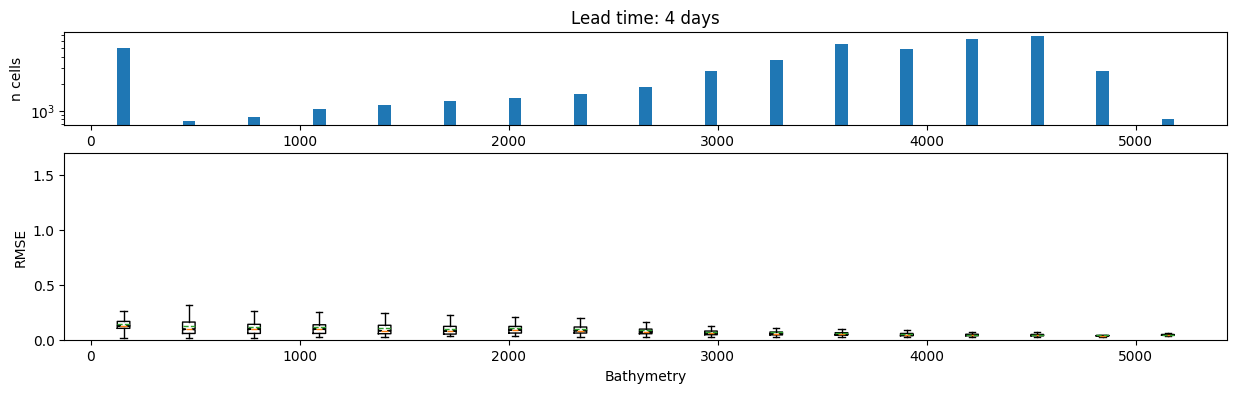

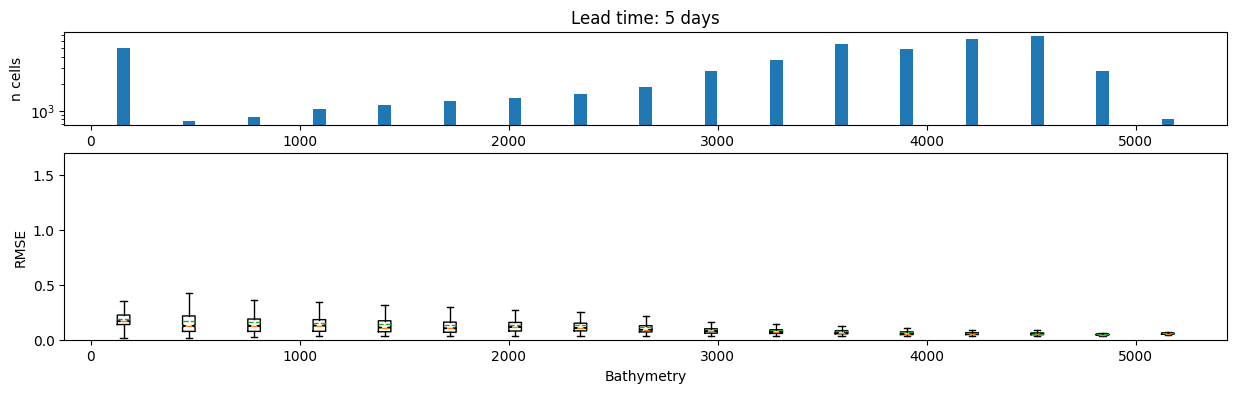

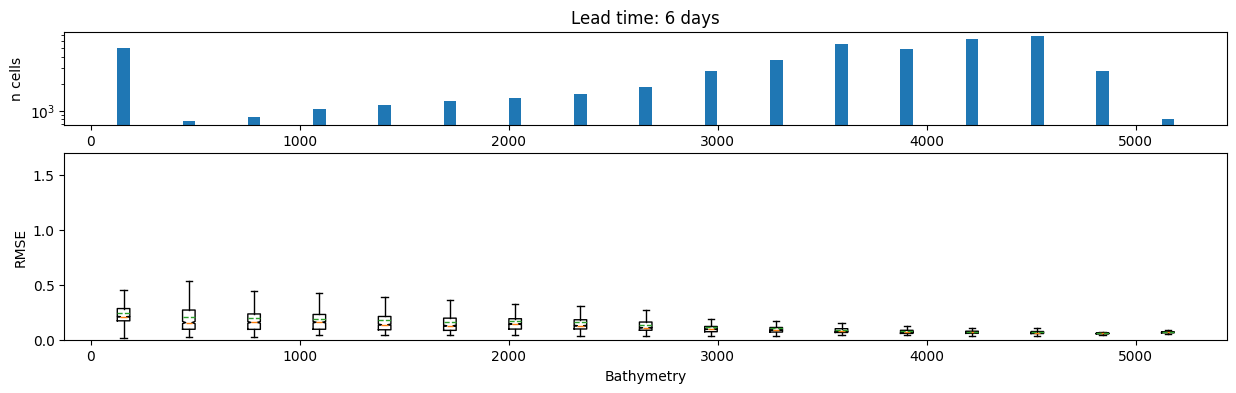

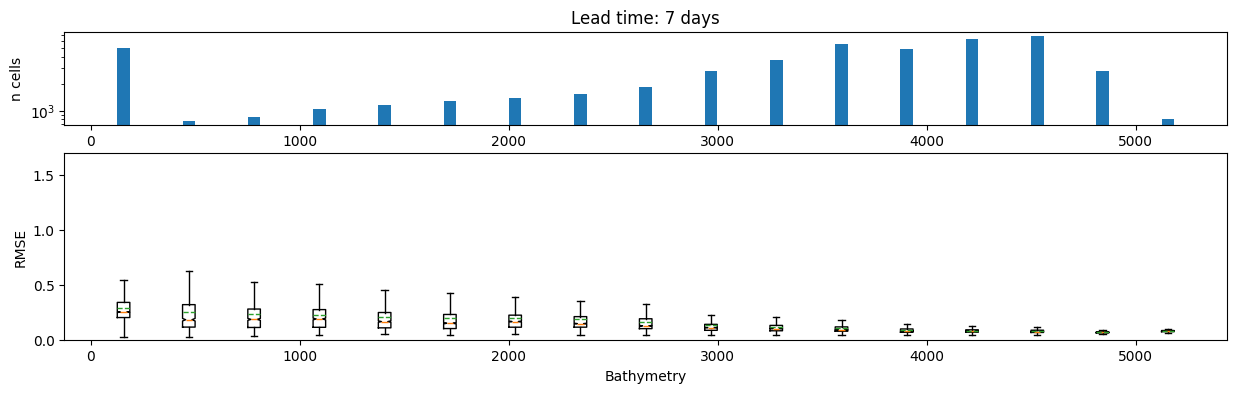

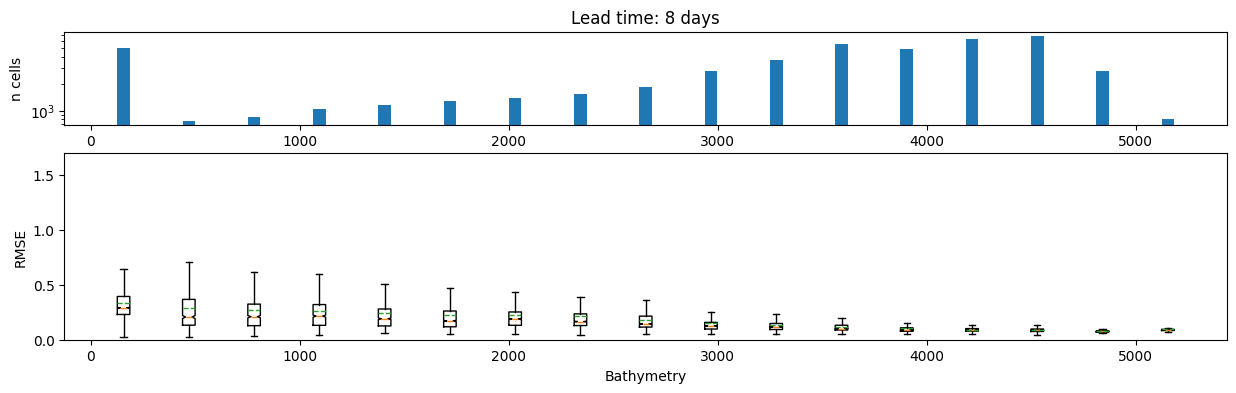

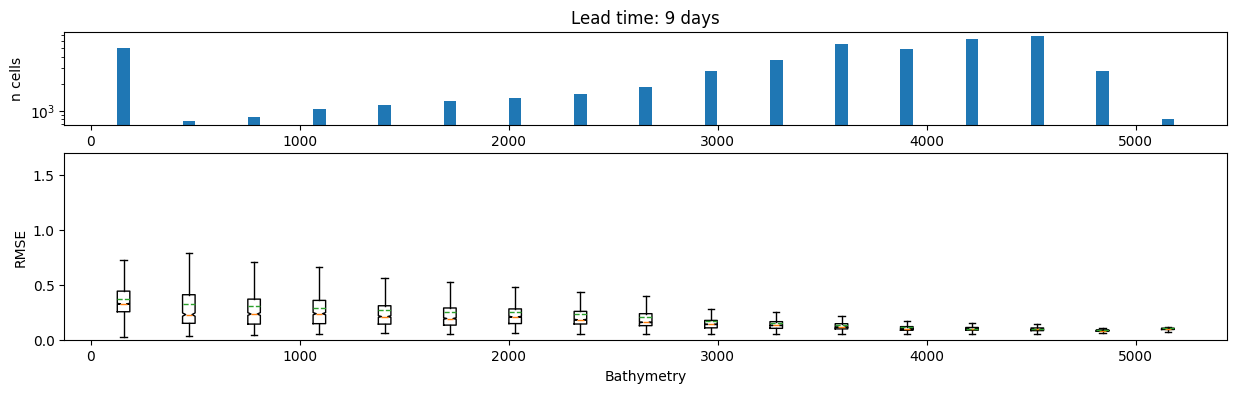

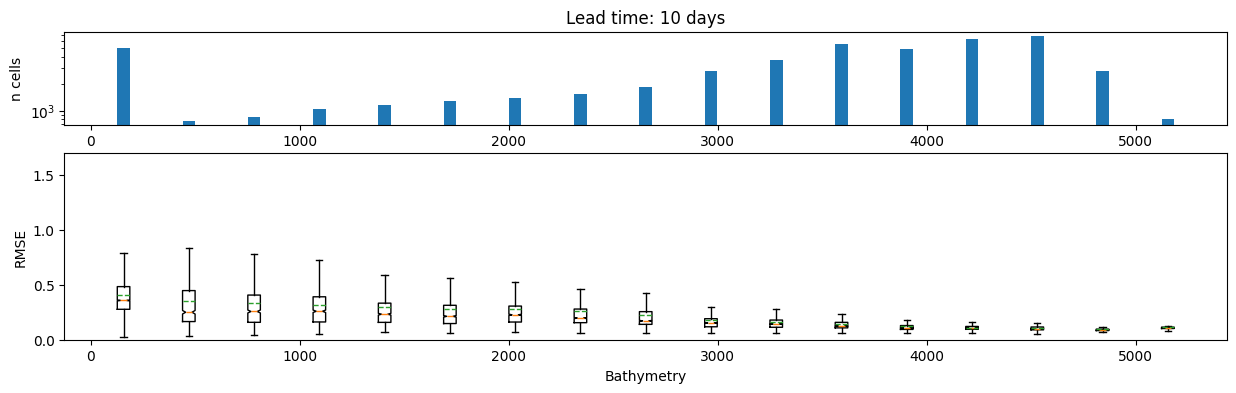

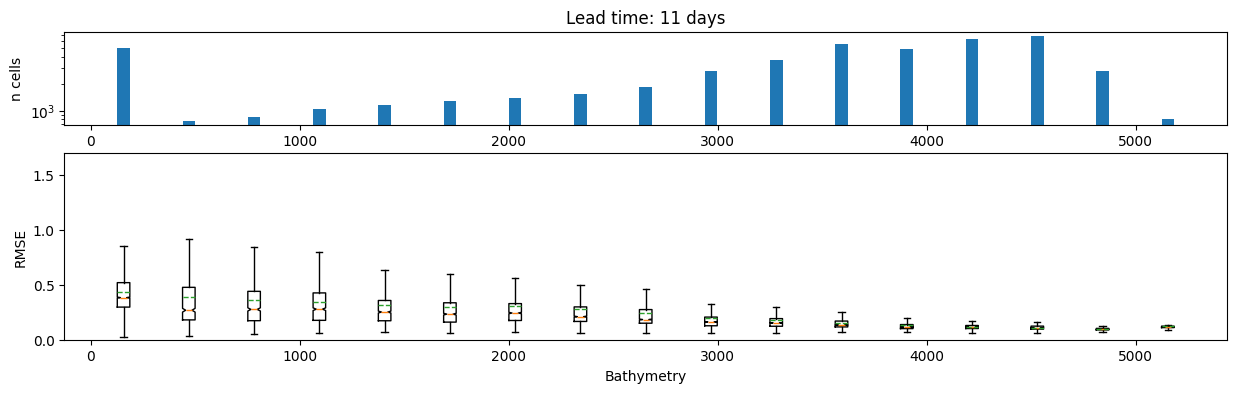

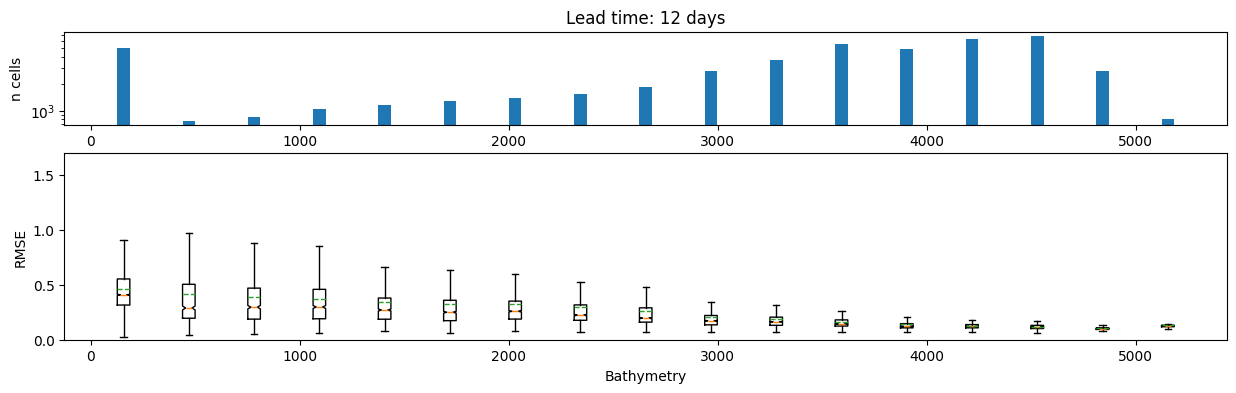

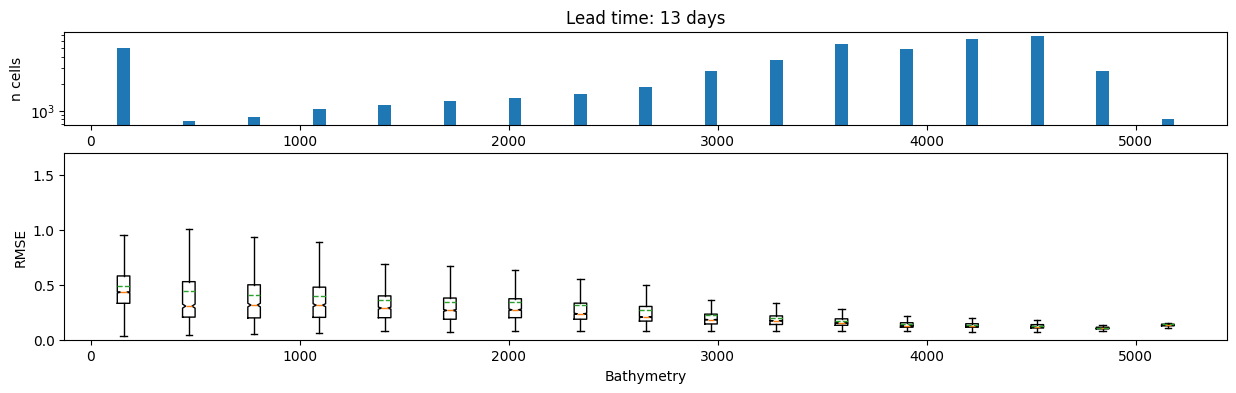

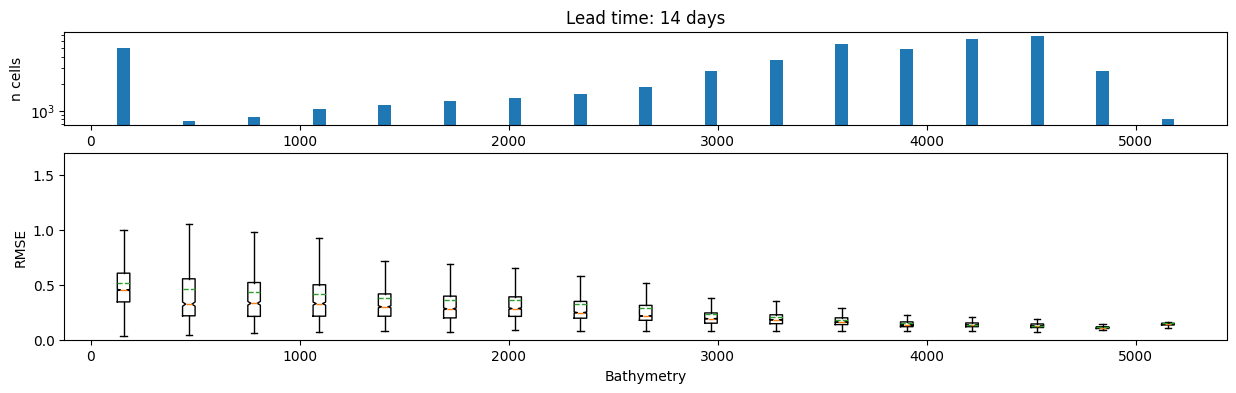

In [18]:
# Get RMSE
rmse_da = lead_time_scores['SquaredError']['sst_temperature']
bin_type = 'linear'
rmse_binned = get_binned_rmse_by_array(rmse_da, bathy, bin_type=bin_type)

# Posiciones reales en el eje logarítmico
positions = [group.mid for group in rmse_binned.groups.keys()]

from matplotlib.ticker import FormatStrFormatter

for lead_time in range(15):
    fig, axs = plt.subplots(2, 1, figsize=(15, 4), gridspec_kw={'height_ratios': [1, 2]})
    # Boxplot en las posiciones reales
    axs[0].bar(
        positions, 
        rmse_binned.count().isel(lead_time=lead_time).values, 
        width=np.array(positions)*0.11 if bin_type == 'log' else 60,
        )
    axs[0].loglog() if bin_type == 'log' else axs[0].set_yscale('log')
    axs[0].set_ylabel('n cells');
    axs[0].set_title(f'Lead time: {lead_time} days');
    axs[1].boxplot(
        [rmse_bin[1].isel(lead_time=lead_time).values for rmse_bin in rmse_binned], 
        positions=positions, 
        widths=np.array(positions)*0.11 if bin_type == 'log' else 60,
        showmeans=True, 
        meanline=True, 
        notch=True,
        showfliers=False,
    );
    # Rotate x labels
    axs[1].set_xscale('log') if bin_type == 'log' else axs[1].set_xscale('linear')
    axs[1].set_ylabel('RMSE');
    axs[1].set_xlabel('Bathymetry');
    axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'));
    axs[1].set_ylim(0, 1.7);
    if lead_time == 14:
        # Save figure
        plt.savefig(f"/home/giovanny/Seacast/reports/figures/rmse_vs_bathymetry_lead_time_{lead_time}.pdf", bbox_inches='tight')

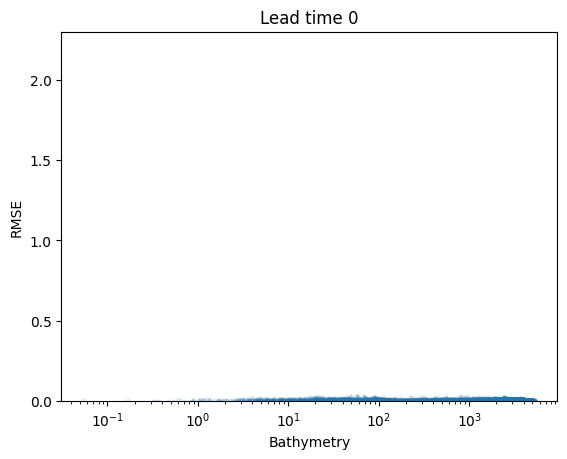

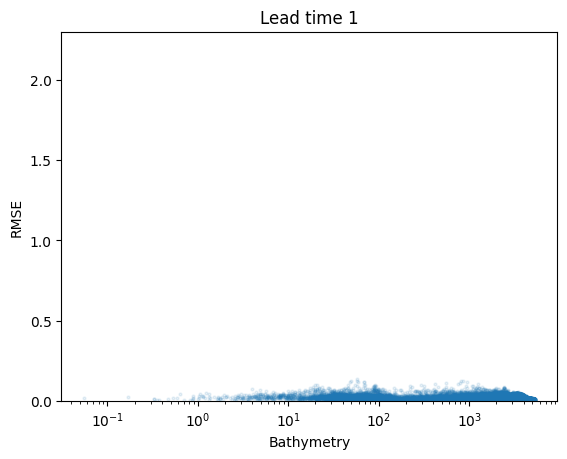

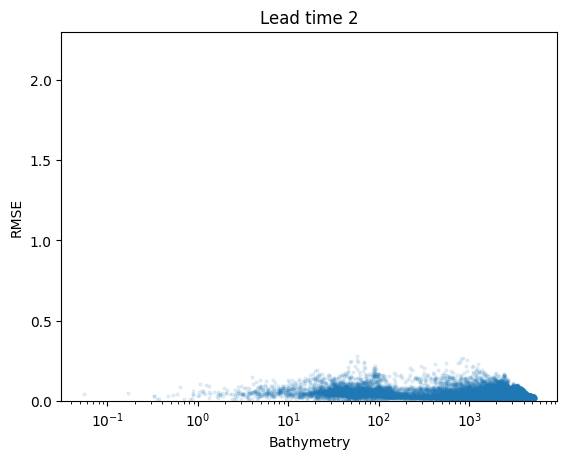

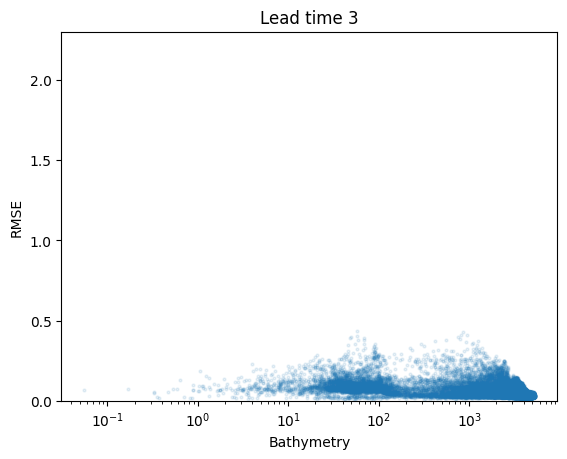

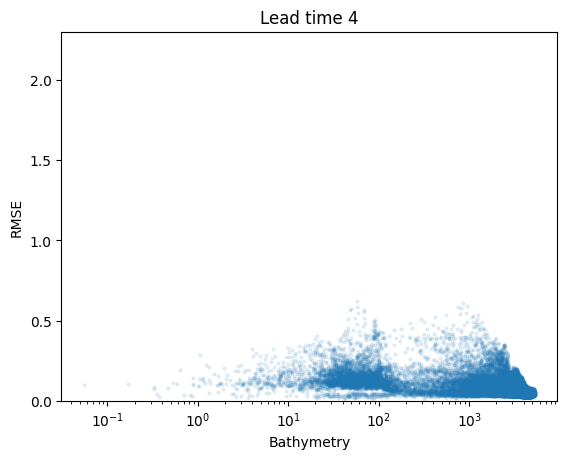

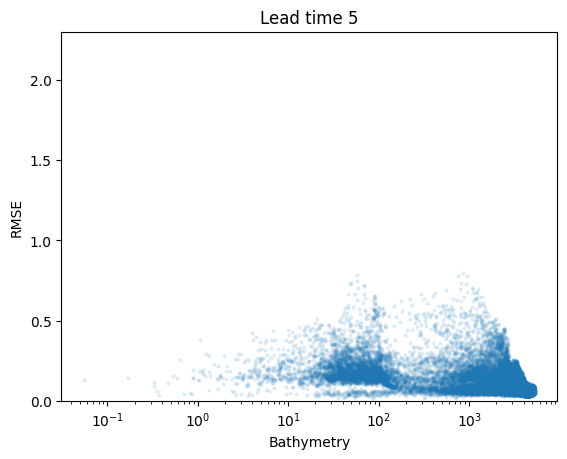

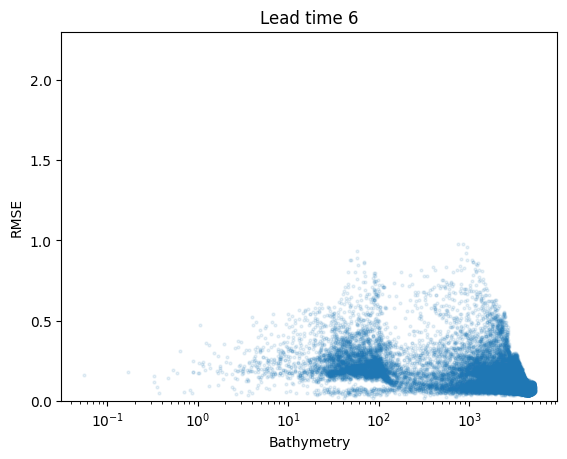

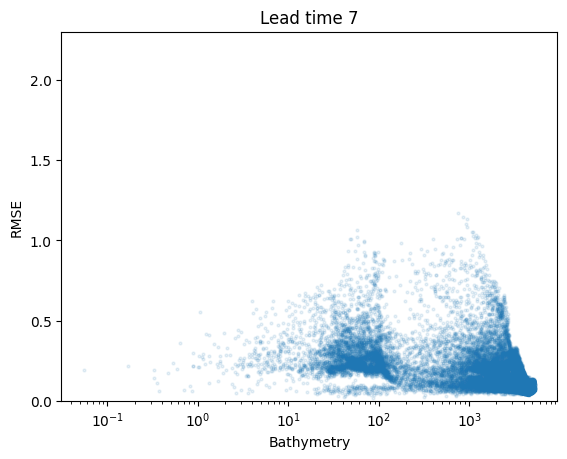

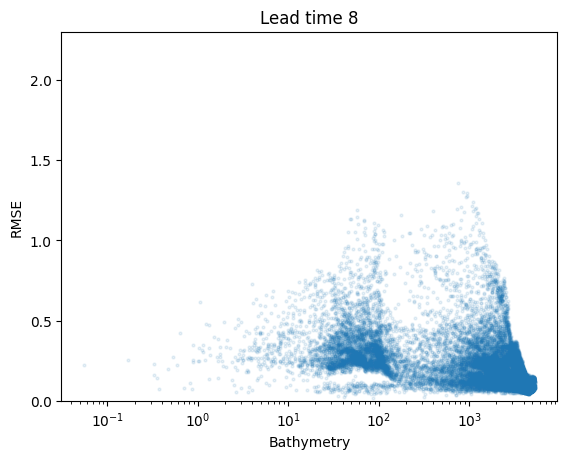

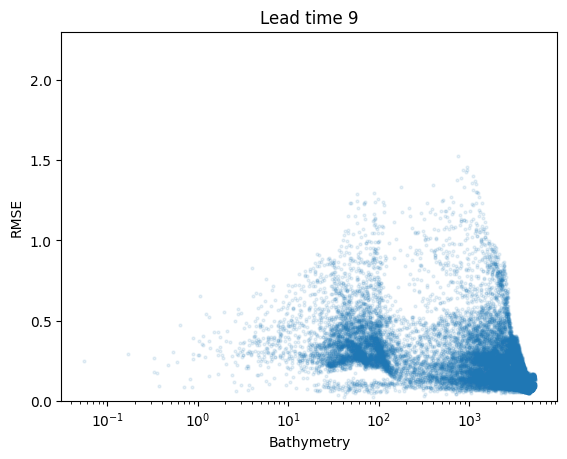

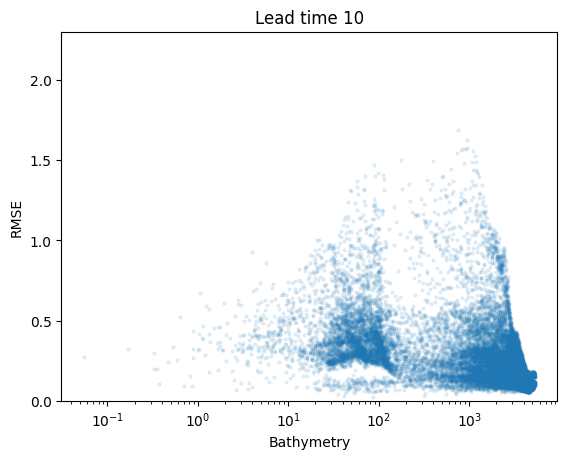

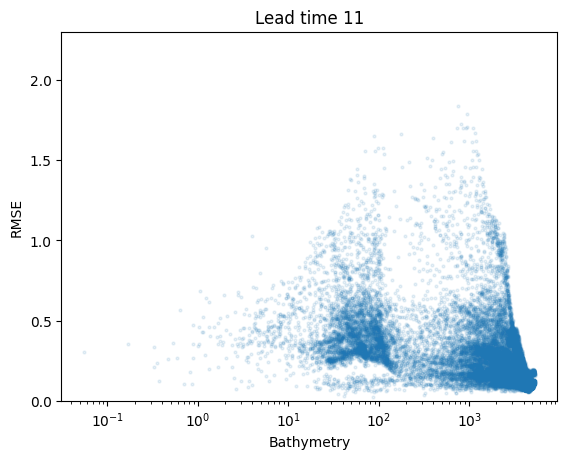

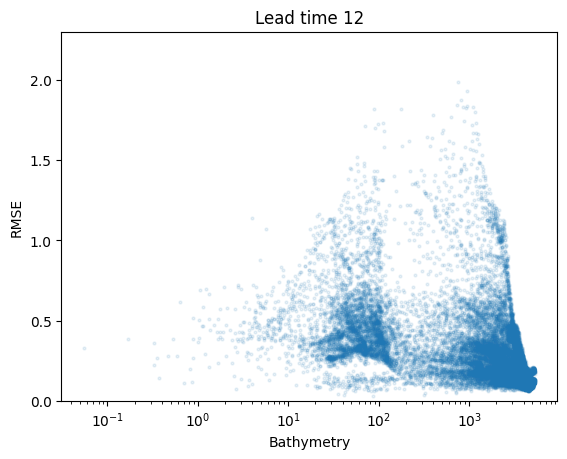

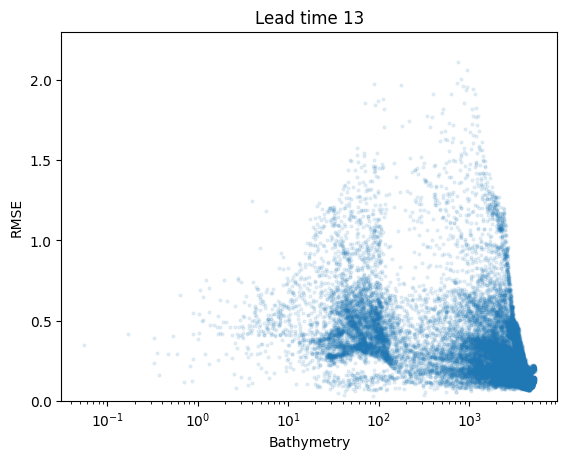

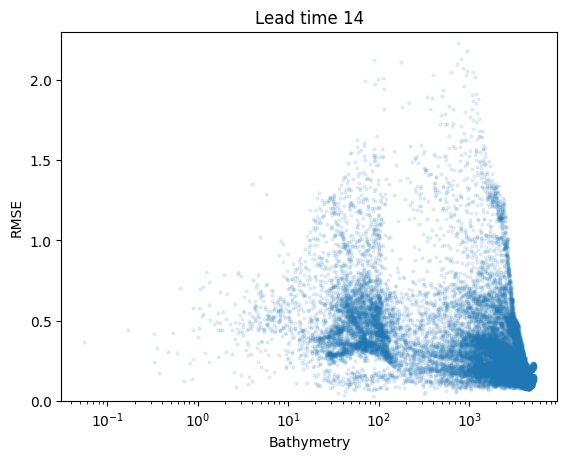

In [19]:
# Load npy file
bathy = np.load('/home/giovanny/Seacast/data/atlantic/static/sea_depth.npy')
lead_time = 0
for lead_time in range(0, 15):
    rmse = lead_time_scores['SquaredError']['sst_temperature'].isel(lead_time=lead_time).data
    plt.scatter(bathy.flatten(), rmse.flatten(), alpha=0.1, s=4)
    plt.xlabel('Bathymetry')
    plt.ylabel('RMSE')
    plt.ylim(0, 2.3)
    plt.xscale('log')
    plt.title(f'Lead time {lead_time}')
    plt.show()

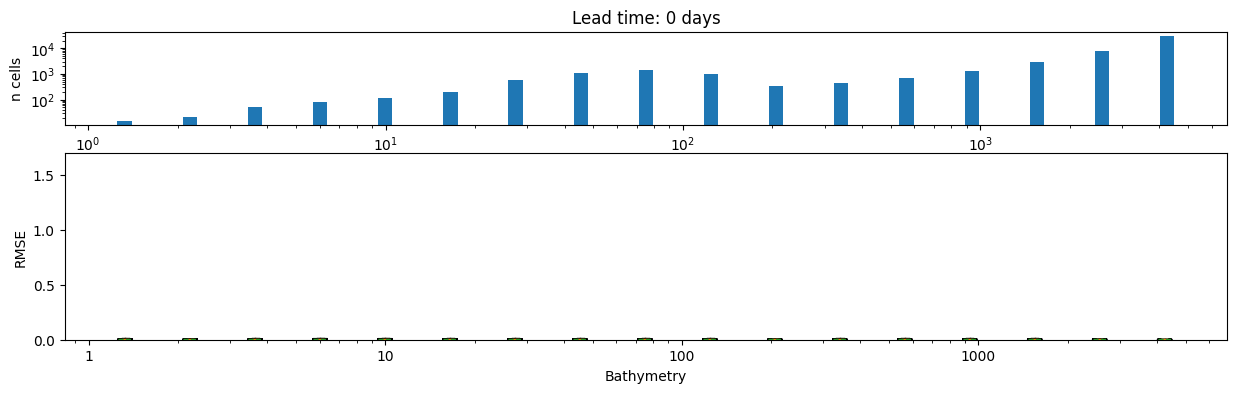

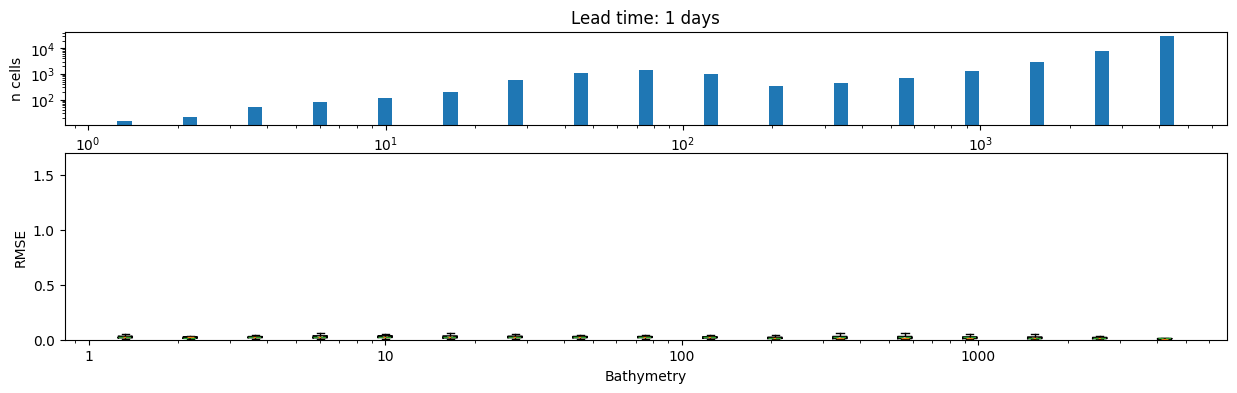

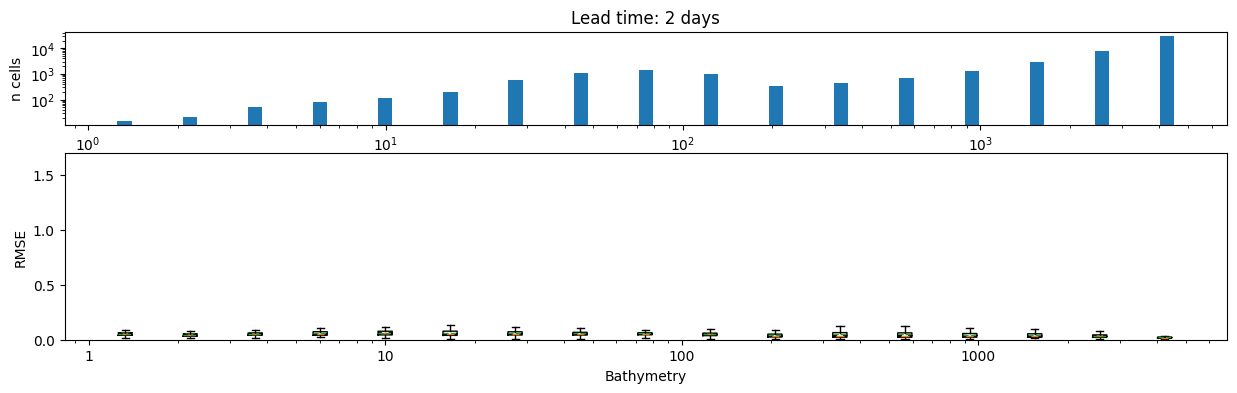

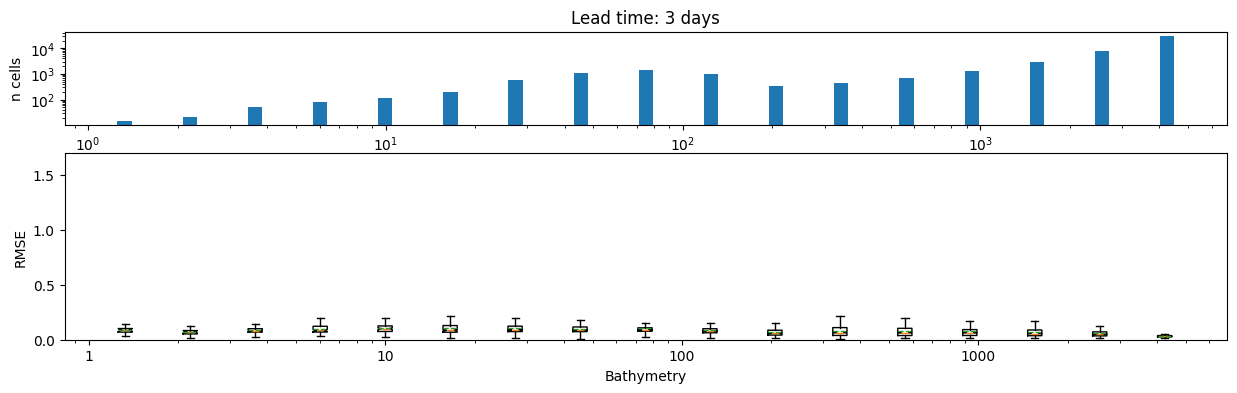

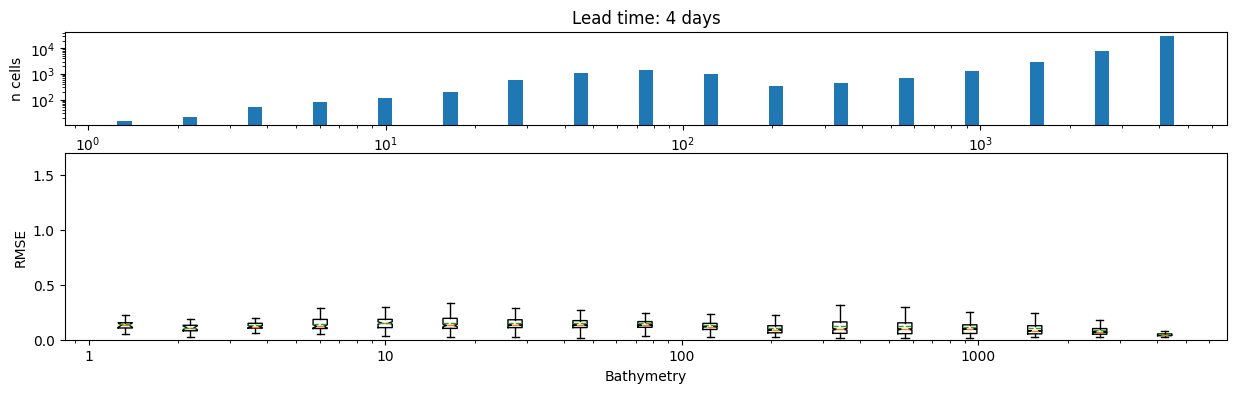

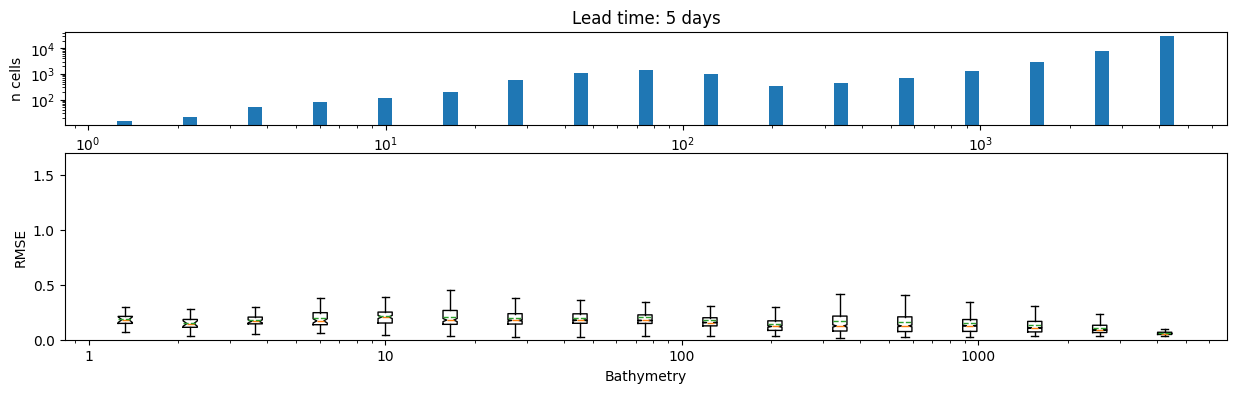

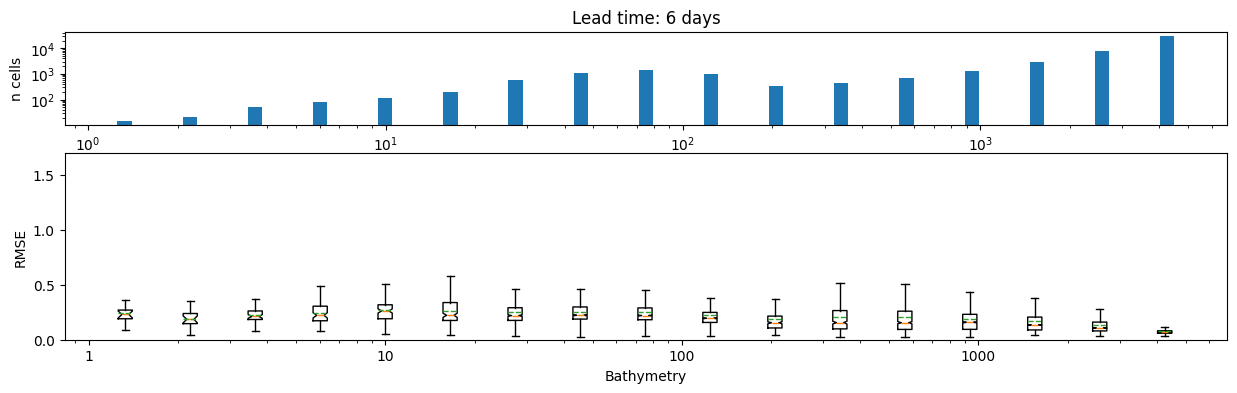

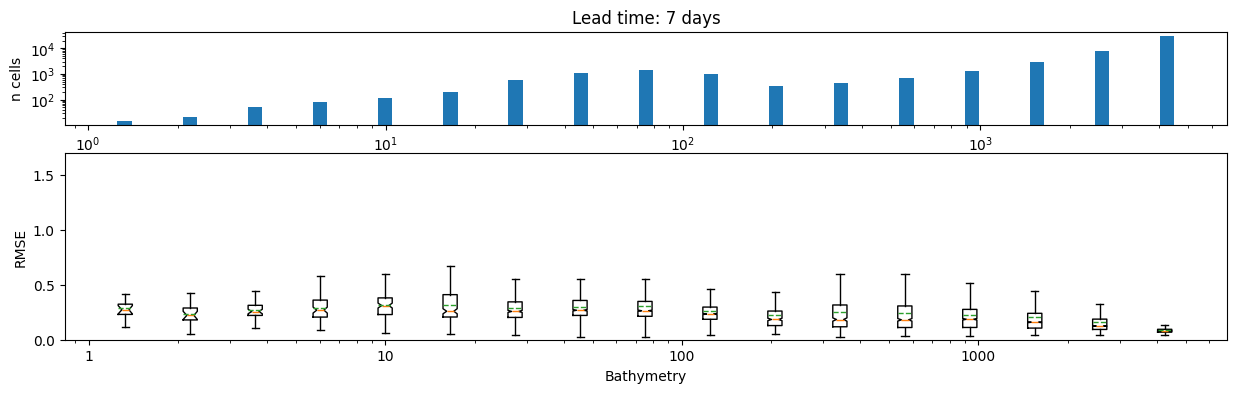

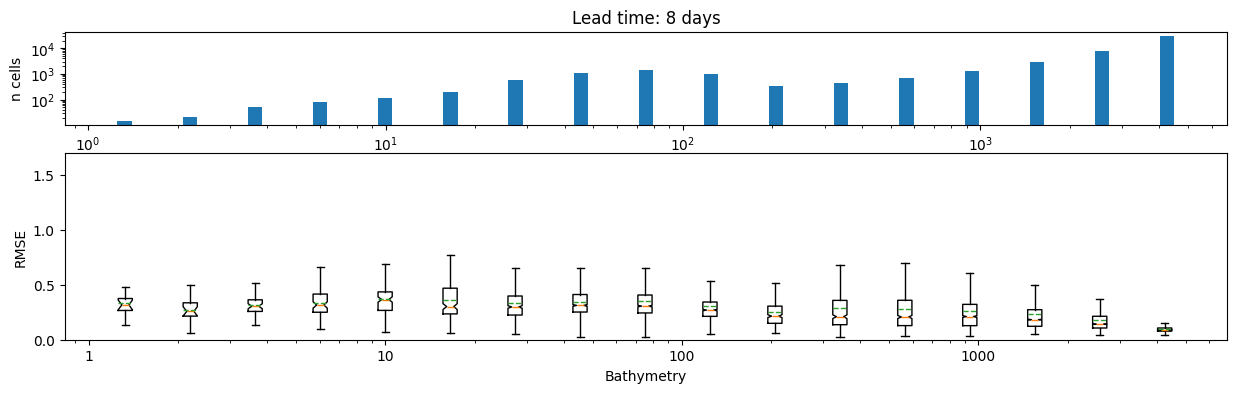

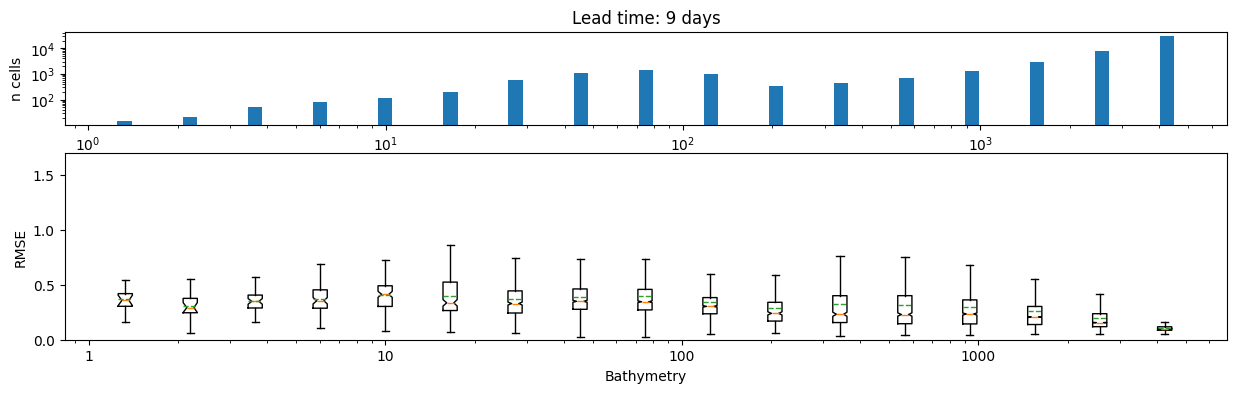

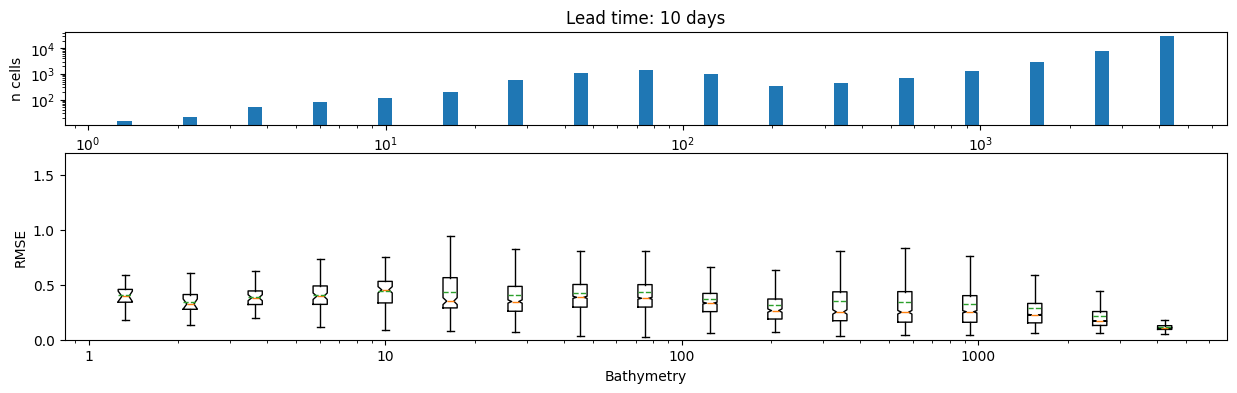

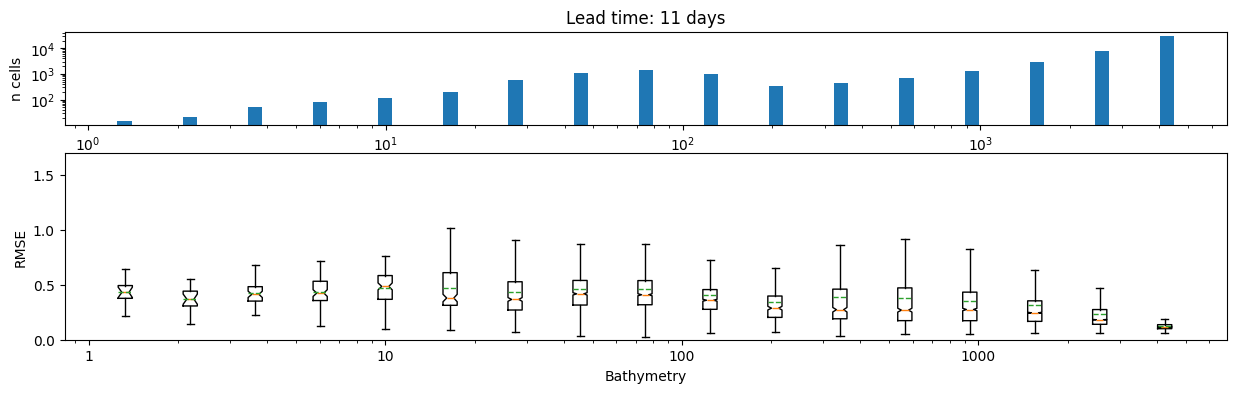

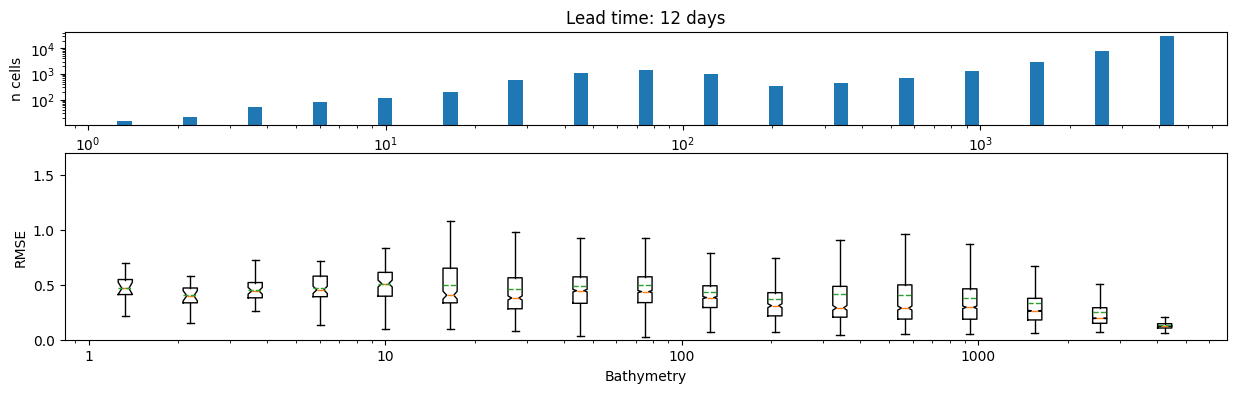

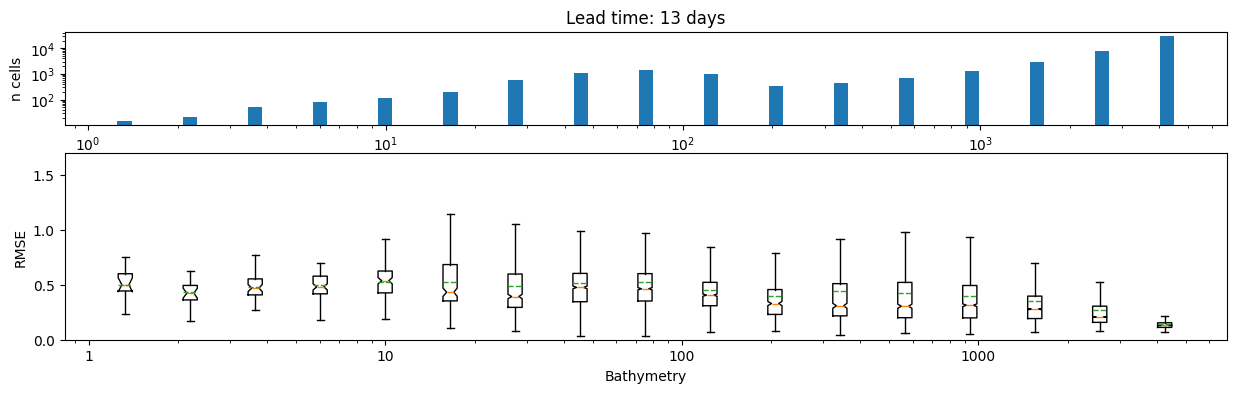

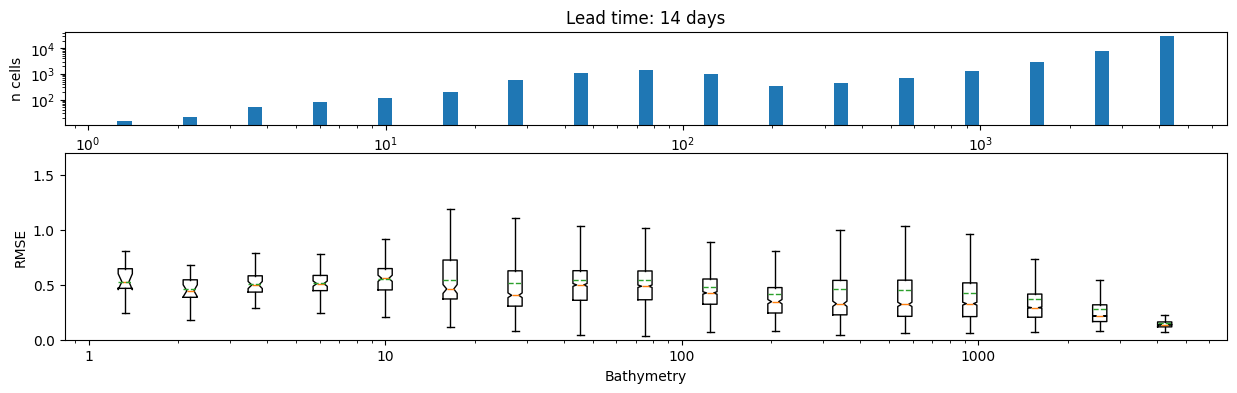

In [20]:
# Get RMSE
rmse_da = lead_time_scores['SquaredError']['sst_temperature']
bin_type = 'log'
rmse_binned = get_binned_rmse_by_array(rmse_da, bathy, bin_type=bin_type)

# Posiciones reales en el eje logarítmico
positions = [group.mid for group in rmse_binned.groups.keys()]

from matplotlib.ticker import FormatStrFormatter

for lead_time in range(15):
    fig, axs = plt.subplots(2, 1, figsize=(15, 4), gridspec_kw={'height_ratios': [1, 2]})
    # Boxplot en las posiciones reales
    axs[0].bar(
        positions, 
        rmse_binned.count().isel(lead_time=lead_time).values, 
        width=np.array(positions)*0.11 if bin_type == 'log' else 60,
        )
    axs[0].loglog() if bin_type == 'log' else axs[0].set_yscale('log')
    axs[0].set_ylabel('n cells');
    axs[0].set_title(f'Lead time: {lead_time} days');
    axs[1].boxplot(
        [rmse_bin[1].isel(lead_time=lead_time).values for rmse_bin in rmse_binned], 
        positions=positions, 
        widths=np.array(positions)*0.11 if bin_type == 'log' else 60,
        showmeans=True, 
        meanline=True, 
        notch=True,
        showfliers=False,
    );
    # Rotate x labels
    axs[1].set_xscale('log') if bin_type == 'log' else axs[1].set_xscale('linear')
    axs[1].set_ylabel('RMSE');
    axs[1].set_xlabel('Bathymetry');
    axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'));
    axs[1].set_ylim(0, 1.7);

## Experiment 2: N nodes and bathymetry
---

In [329]:
import re
from enum import Enum
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [330]:
# Create a Enums for different types
class NNodes(Enum):
    def __init__(self, num, alias):
        self.num = num
        self.alias = alias

    N14_9 = ("14_9", "5_4")
    N20_9 = ("20_9", "6_4")
    N34_20 = ("34_20", "8_6")
    N52_27 = ("52_27", "10_7")
    N159_78 = ("159_78", "17_12")

    @classmethod
    def get(cls, key):
        for member in cls:
            if key in (member.num, member.alias, member.name):
                return member
        raise ValueError(f"{key} no corresponde a ningún miembro")

class TypeMesh(Enum):
    crossing_edges = 'crossing_edges'
    non_crossing_edges = 'non_crossing_edges'
    bathymetry = 'bathymetry'
    fps = 'fps'

class TypeScore(Enum):
    RMSE = 'SquaredError'
    MAE = 'AbsoluteError'
    Bias = 'Error'

class TypeVariable(Enum):
    sst_temperature = 'sst_temperature'

class LeadTime(Enum):
    one_lead_day = np.array(86400000000000, dtype='timedelta64[ns]')
    two_lead_days = np.array(172800000000000, dtype='timedelta64[ns]')
    three_lead_days = np.array(259200000000000, dtype='timedelta64[ns]')
    four_lead_days = np.array(345600000000000, dtype='timedelta64[ns]')
    five_lead_days = np.array(432000000000000, dtype='timedelta64[ns]')
    six_lead_days = np.array(518400000000000, dtype='timedelta64[ns]')
    seven_lead_days = np.array(604800000000000, dtype='timedelta64[ns]')
    eight_lead_days = np.array(691200000000000, dtype='timedelta64[ns]')
    nine_lead_days = np.array(777600000000000, dtype='timedelta64[ns]')
    ten_lead_days = np.array(864000000000000, dtype='timedelta64[ns]')
    eleven_lead_days = np.array(950400000000000, dtype='timedelta64[ns]')
    twelve_lead_days = np.array(1036800000000000, dtype='timedelta64[ns]')
    thirteen_lead_days = np.array(1123200000000000, dtype='timedelta64[ns]')
    fourteen_lead_days = np.array(1209600000000000, dtype='timedelta64[ns]')
    fifteen_lead_days = np.array(1296000000000000, dtype='timedelta64[ns]')

In [331]:
# data_processing.py
# ------------------
# Convert experiments to a nested dictionary of statistics
def as_stats_dict(
    experiments: List[StatsLoader],
    agg_dims: List[str]
    ) -> Dict[TypeMesh, Dict[NNodes, Dict[TypeScore, Dict[TypeVariable, xr.DataArray]]]]:
    """Convert a list of experiments into a nested dictionary of statistics grouped by:
        - The last character of the experiment name (assumed to be an integer).
        - The substring of the experiment name before the first occurrence of '_m'.
    """
    # Regular expression patterns
    patron_key1 = r'^.*?(?=_m)'
    patron_key2 = r'(?<=_m_)\d+_\d+'
    # Initialize the nested dictionary
    d = defaultdict(dict)
    for exp in tqdm(experiments):
        with StatsAggSession(exp) as stats:
            lead_time_scores = stats.agg_scores(
                agg_dims,
                )
            key_1 = TypeMesh(re.search(patron_key1, exp.name).group(0))
            key_2 = NNodes.get(re.search(patron_key2, exp.name).group(0))
            d[key_1][key_2] = lead_time_scores
    return d

In [ ]:
%%time
# number of nodes sequence for unstructured and structured meshes
unstructured_nodes = ["14_9", "20_9", "34_20", "52_27", "159_78"]
# mesh file names sequences
mesh = TypeMesh.bathymetry
bathy_mesh_names = [f"bathymetry_m_{node}_g2mm2g_4" for node in unstructured_nodes]
# all experiment names
experiments_names = (bathy_mesh_names)
    
# load all experiments
experiments = [
    StatsLoader(os.path.join("~/Seacast/output/increase_n_nodes", exp_name)) 
    for exp_name in experiments_names
    ]

# Create a dictionary of experiments grouped by the last character of the experiment name
exp_dic = as_stats_dict(experiments, ['init_time'])  

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 54.4 s, sys: 55 s, total: 1min 49s
Wall time: 1min 49s


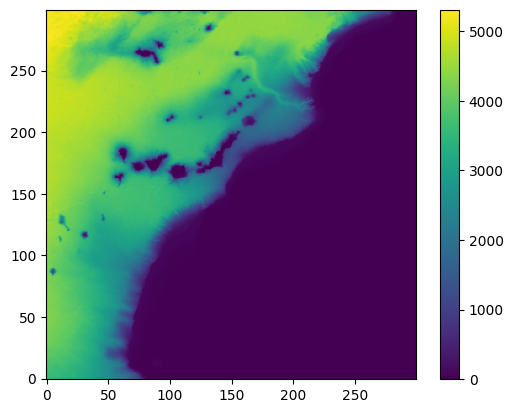

In [333]:
# Load npy file
bathy = np.load('/home/giovanny/Seacast/data/atlantic/static/sea_depth.npy')
plt.imshow(bathy, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

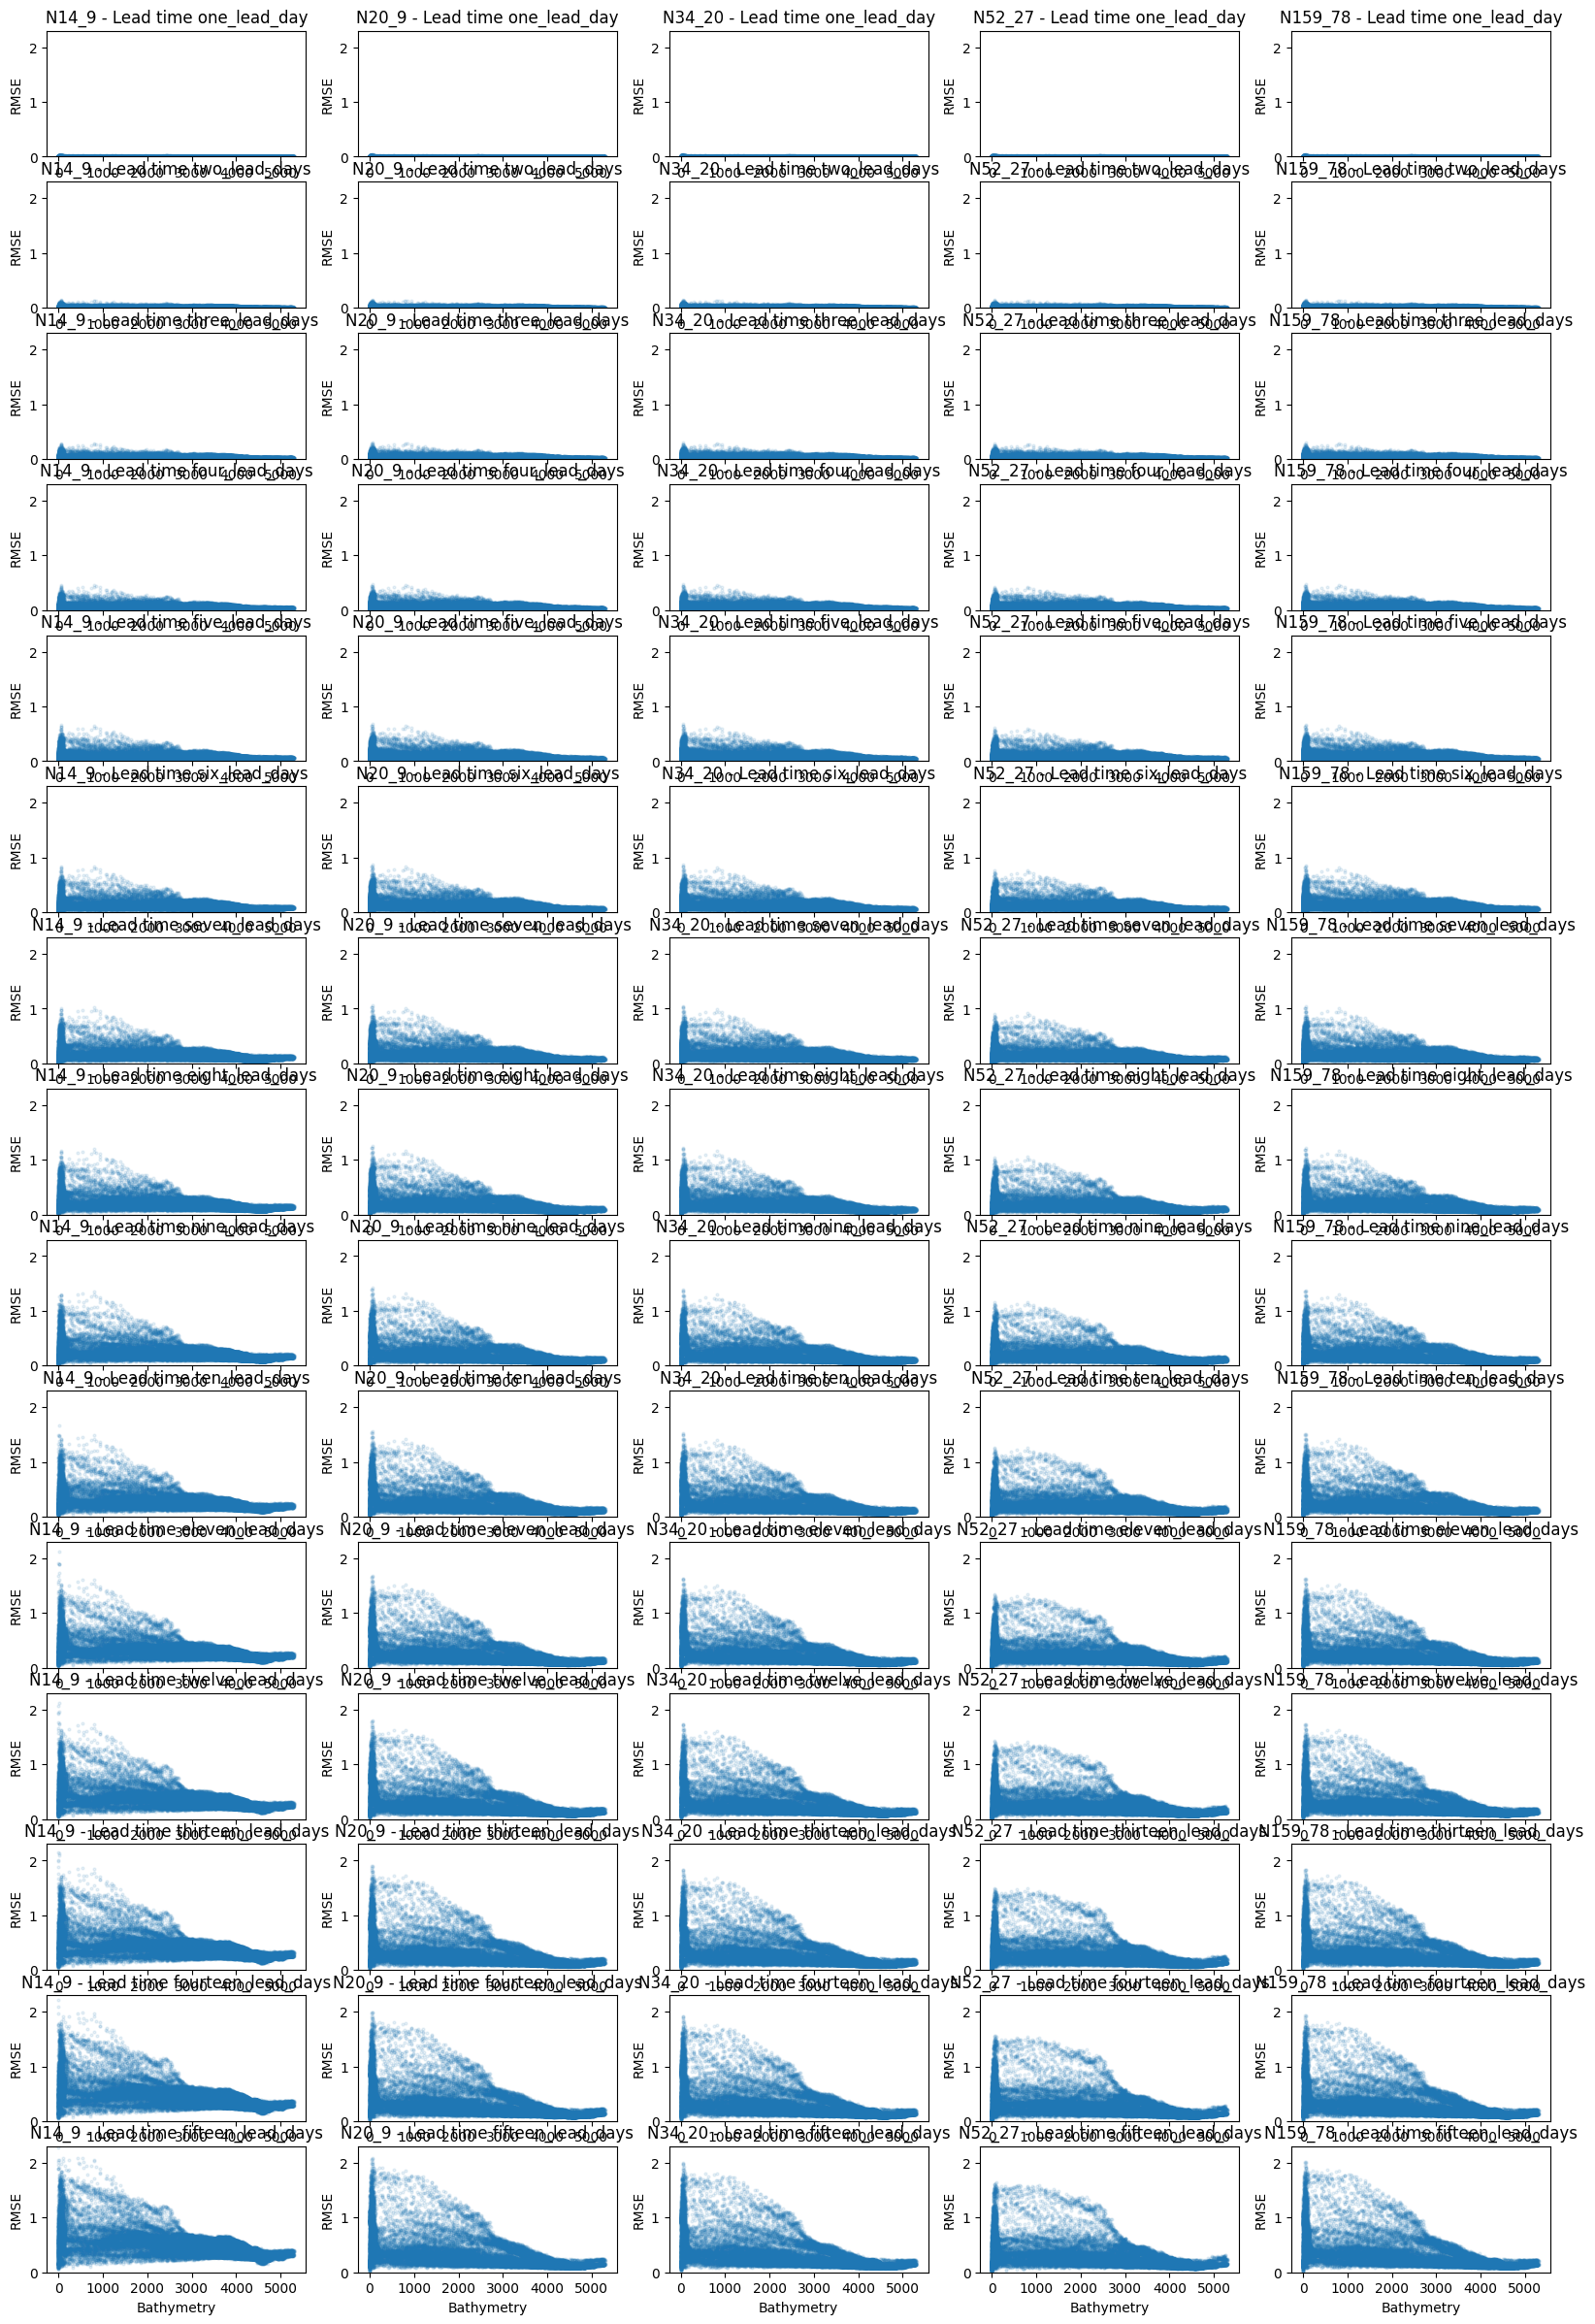

In [ ]:
score = TypeScore.RMSE.value
variable = TypeVariable.sst_temperature.value

fig, axs = plt.subplots(len(LeadTime), len(NNodes), figsize=(20, 30))

for n, n_nodes in enumerate(NNodes):
    for l, lead_time in enumerate(LeadTime):
        rmse_da = exp_dic[mesh][n_nodes][score][variable]
        rmse = rmse_da.sel(lead_time=lead_time.value).data
        axs[l, n].scatter(bathy.flatten(), rmse.flatten(), alpha=0.1, s=4)
        axs[l, n].set_xlabel('Bathymetry')
        axs[l, n].set_ylabel('RMSE')
        axs[l, n].set_ylim(0, 2.3)
        axs[l, n].set_title(f'{n_nodes.name} - Lead time {lead_time.name}')

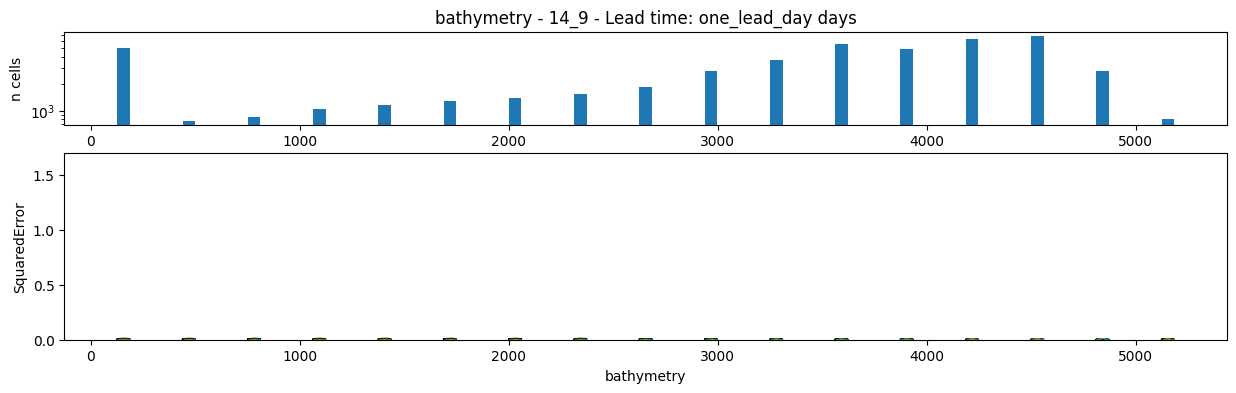

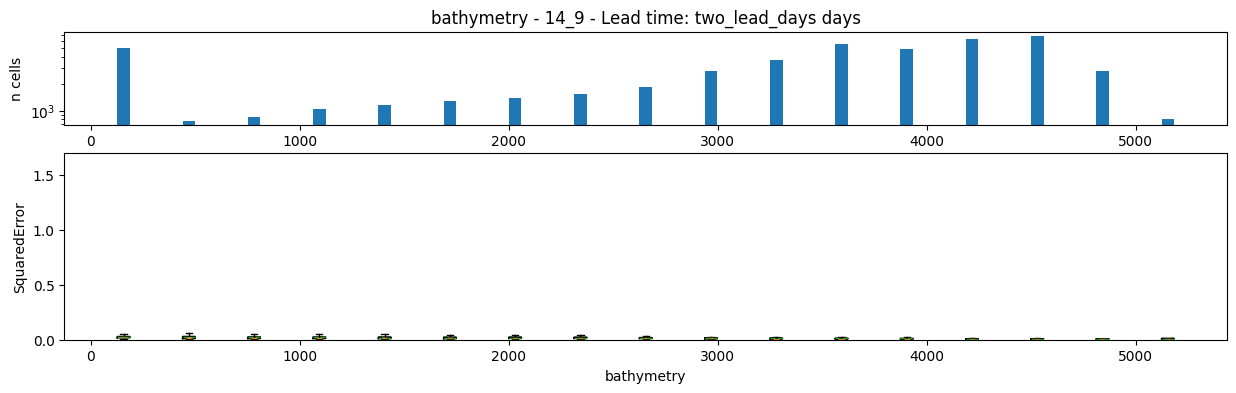

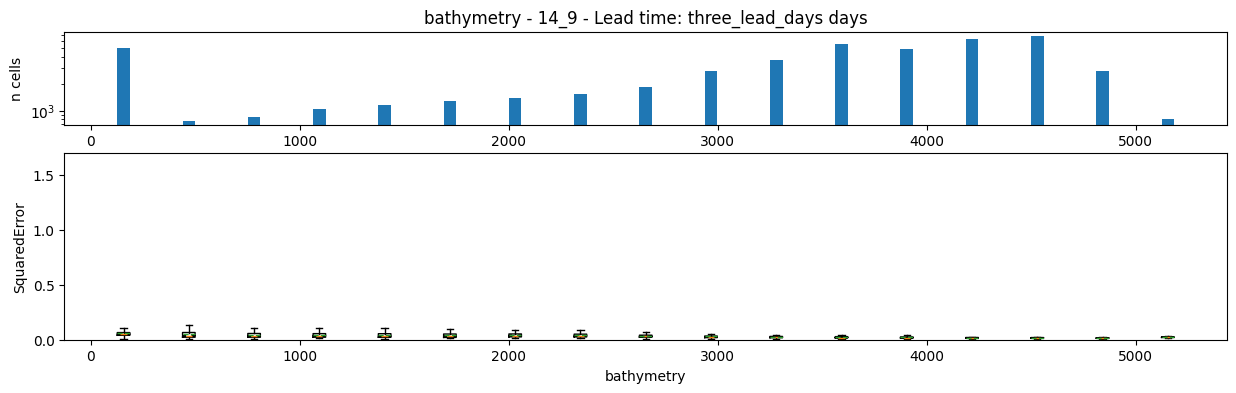

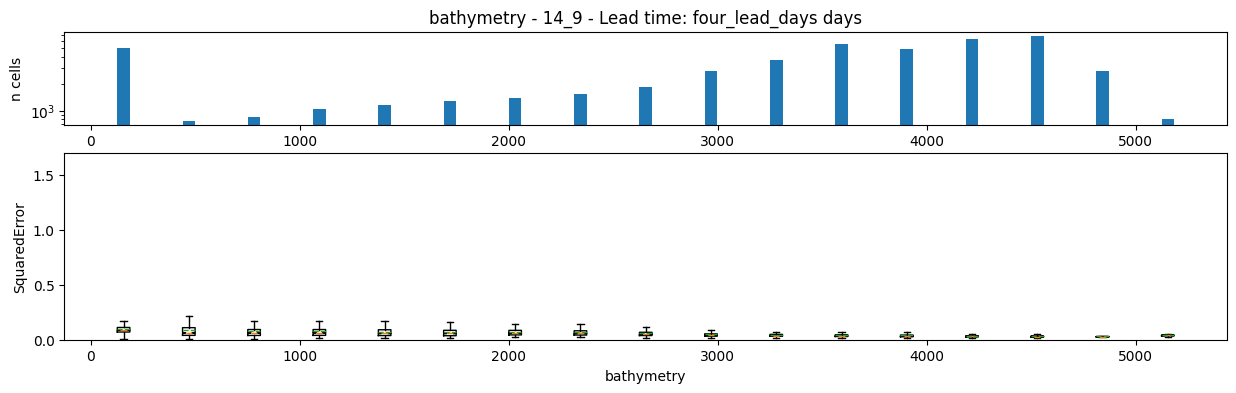

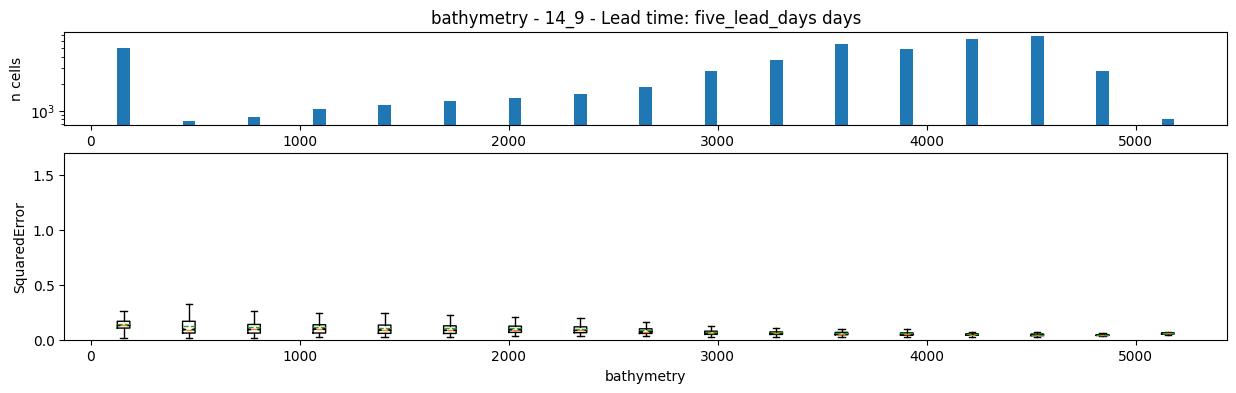

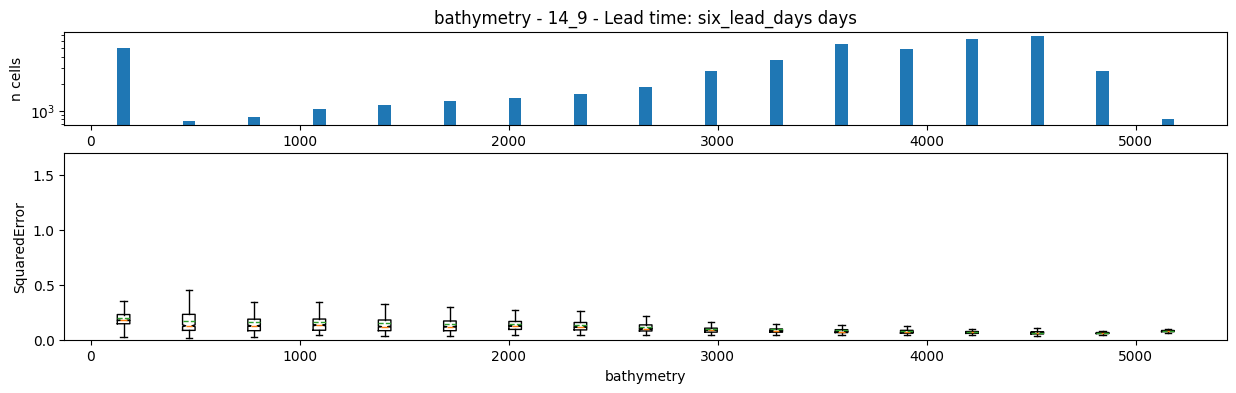

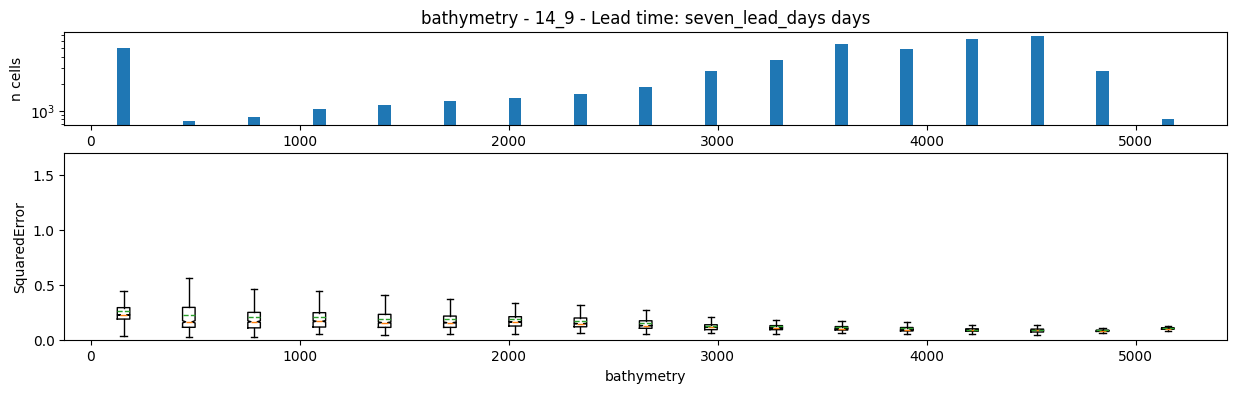

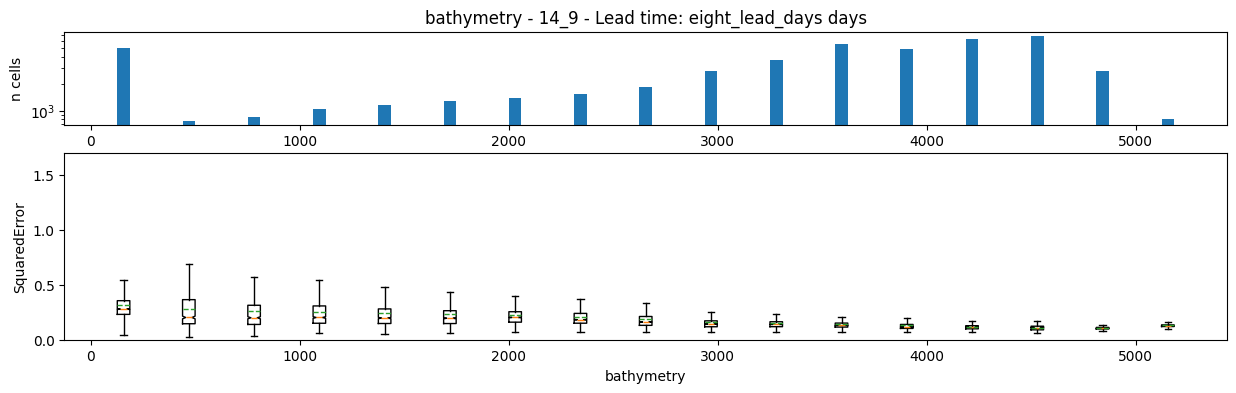

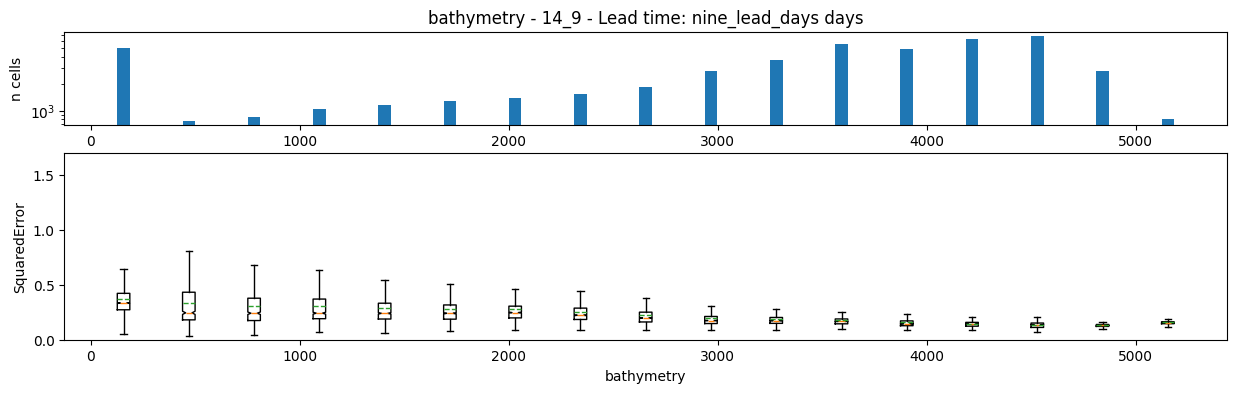

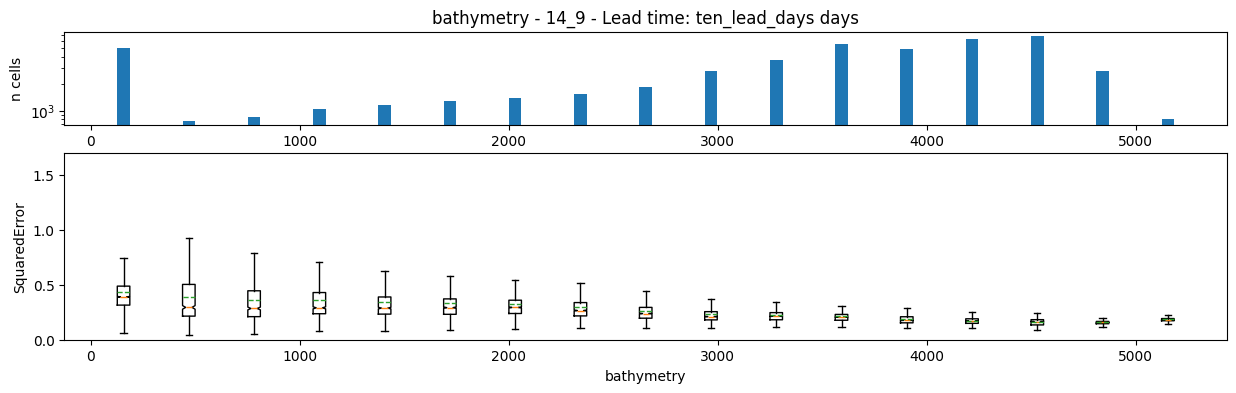

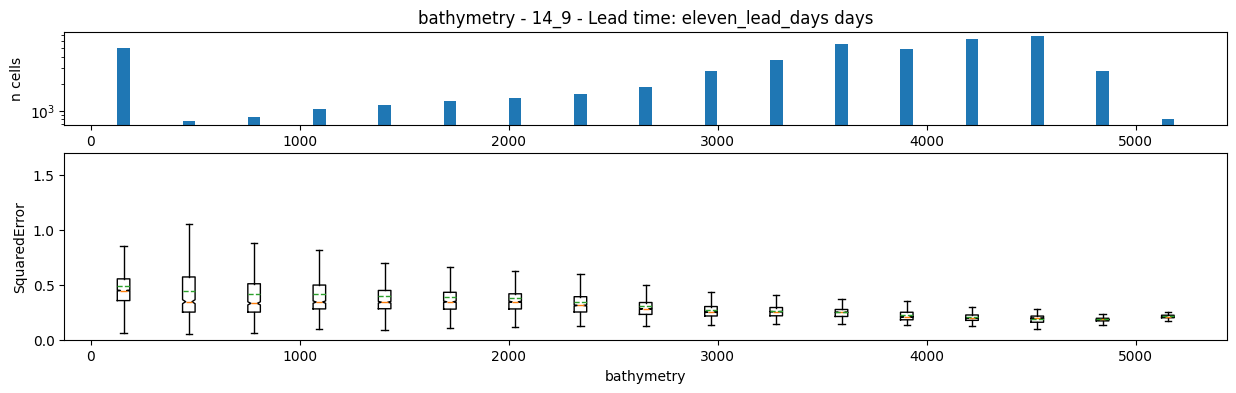

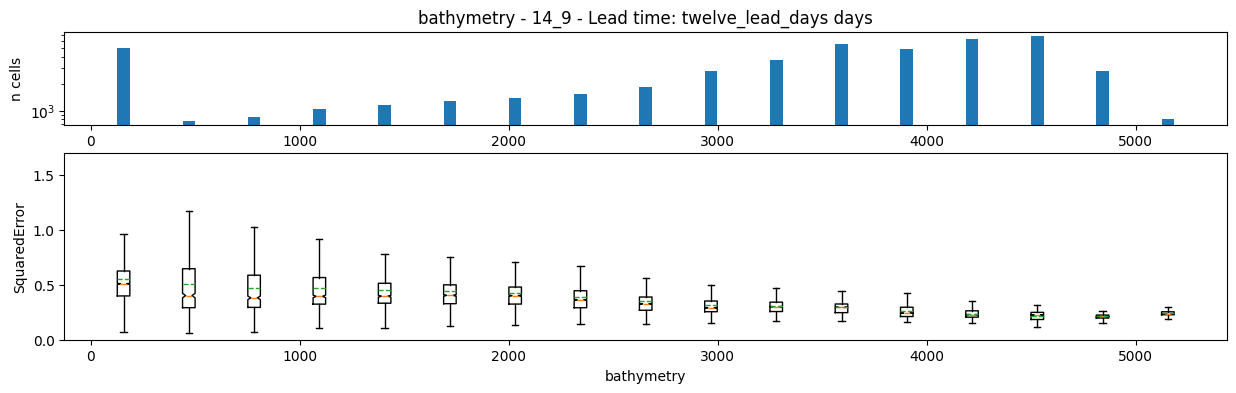

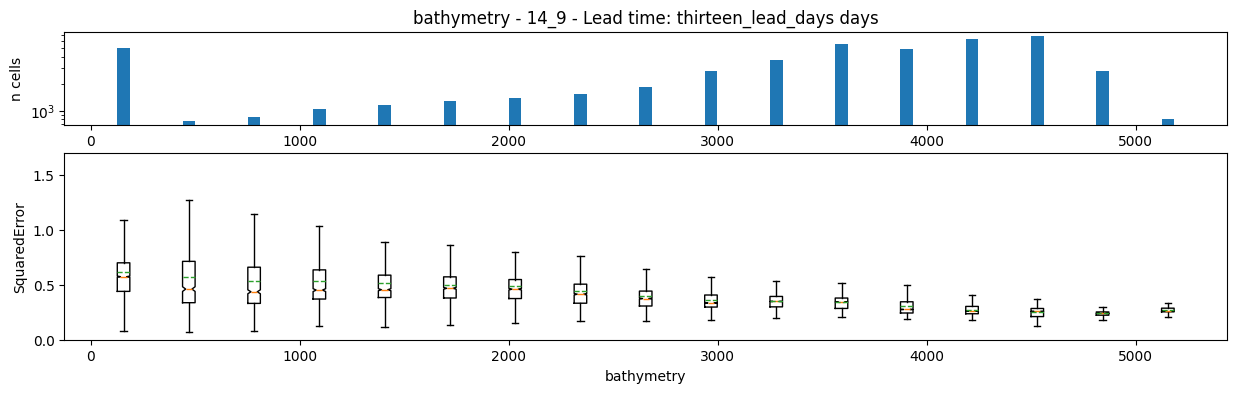

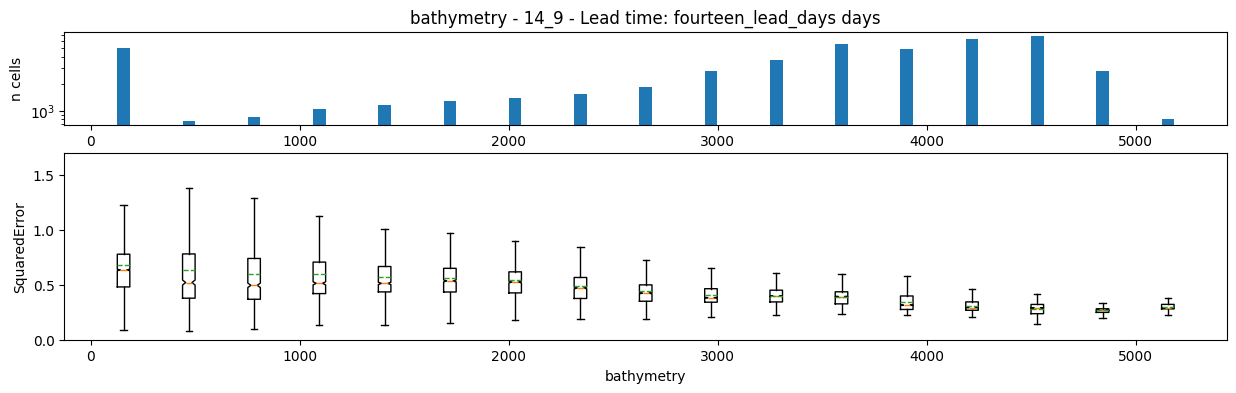

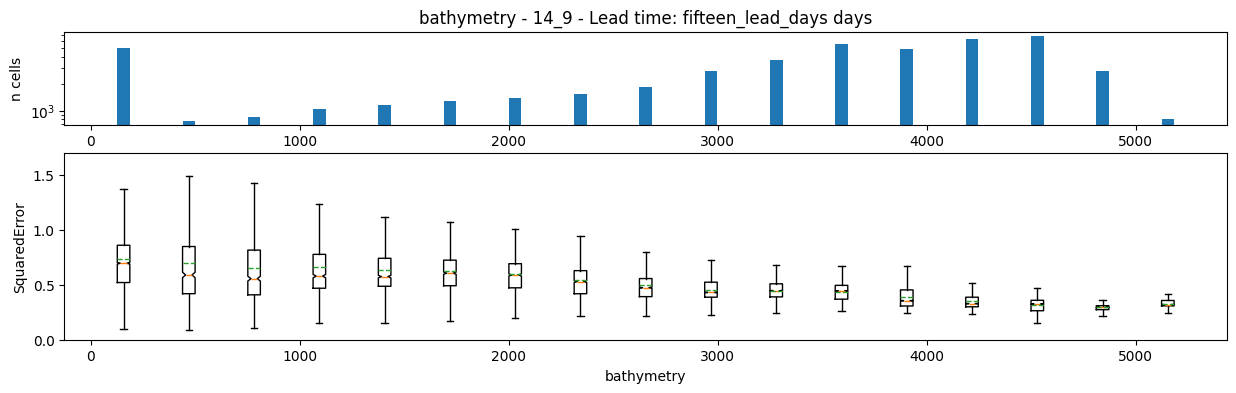

In [ ]:
from matplotlib.ticker import FormatStrFormatter

# Plot a specific score and variable for all experiments
score = TypeScore.RMSE.value
variable = TypeVariable.sst_temperature.value
n_nodes = NNodes.N14_9
rmse_da = exp_dic[mesh][n_nodes][score][variable]
bin_type = 'linear'
rmse_binned = get_binned_rmse_by_array(rmse_da, bathy, bin_type=bin_type)
# Posiciones reales en el eje logarítmico
positions = [group.mid for group in rmse_binned.groups.keys()]
# Plot each score and variable in the grid
for lead_time in LeadTime:
    fig, axs = plt.subplots(2, 1, figsize=(15, 4), gridspec_kw={'height_ratios': [1, 2]})
    # Boxplot en las posiciones reales
    axs[0].bar(
        positions, 
        rmse_binned.count().sel(lead_time=lead_time.value).values, 
        width=np.array(positions)*0.11 if bin_type == 'log' else 60,
        )
    axs[0].loglog() if bin_type == 'log' else axs[0].set_yscale('log')
    axs[0].set_ylabel('n cells');
    axs[0].set_title(f'{mesh.value} - {n_nodes.value[0]} - Lead time: {lead_time.name} days');
    axs[1].boxplot(
        [rmse_bin[1].sel(lead_time=lead_time.value).values for rmse_bin in rmse_binned], 
        positions=positions, 
        widths=np.array(positions)*0.11 if bin_type == 'log' else 60,
        showmeans=True, 
        meanline=True, 
        notch=True,
        showfliers=False,
    );
    # Rotate x labels
    axs[1].set_xscale('log') if bin_type == 'log' else axs[1].set_xscale('linear')
    axs[1].set_ylabel(f'{score}');
    axs[1].set_xlabel('bathymetry');
    axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'));
    axs[1].set_ylim(0, 1.7);

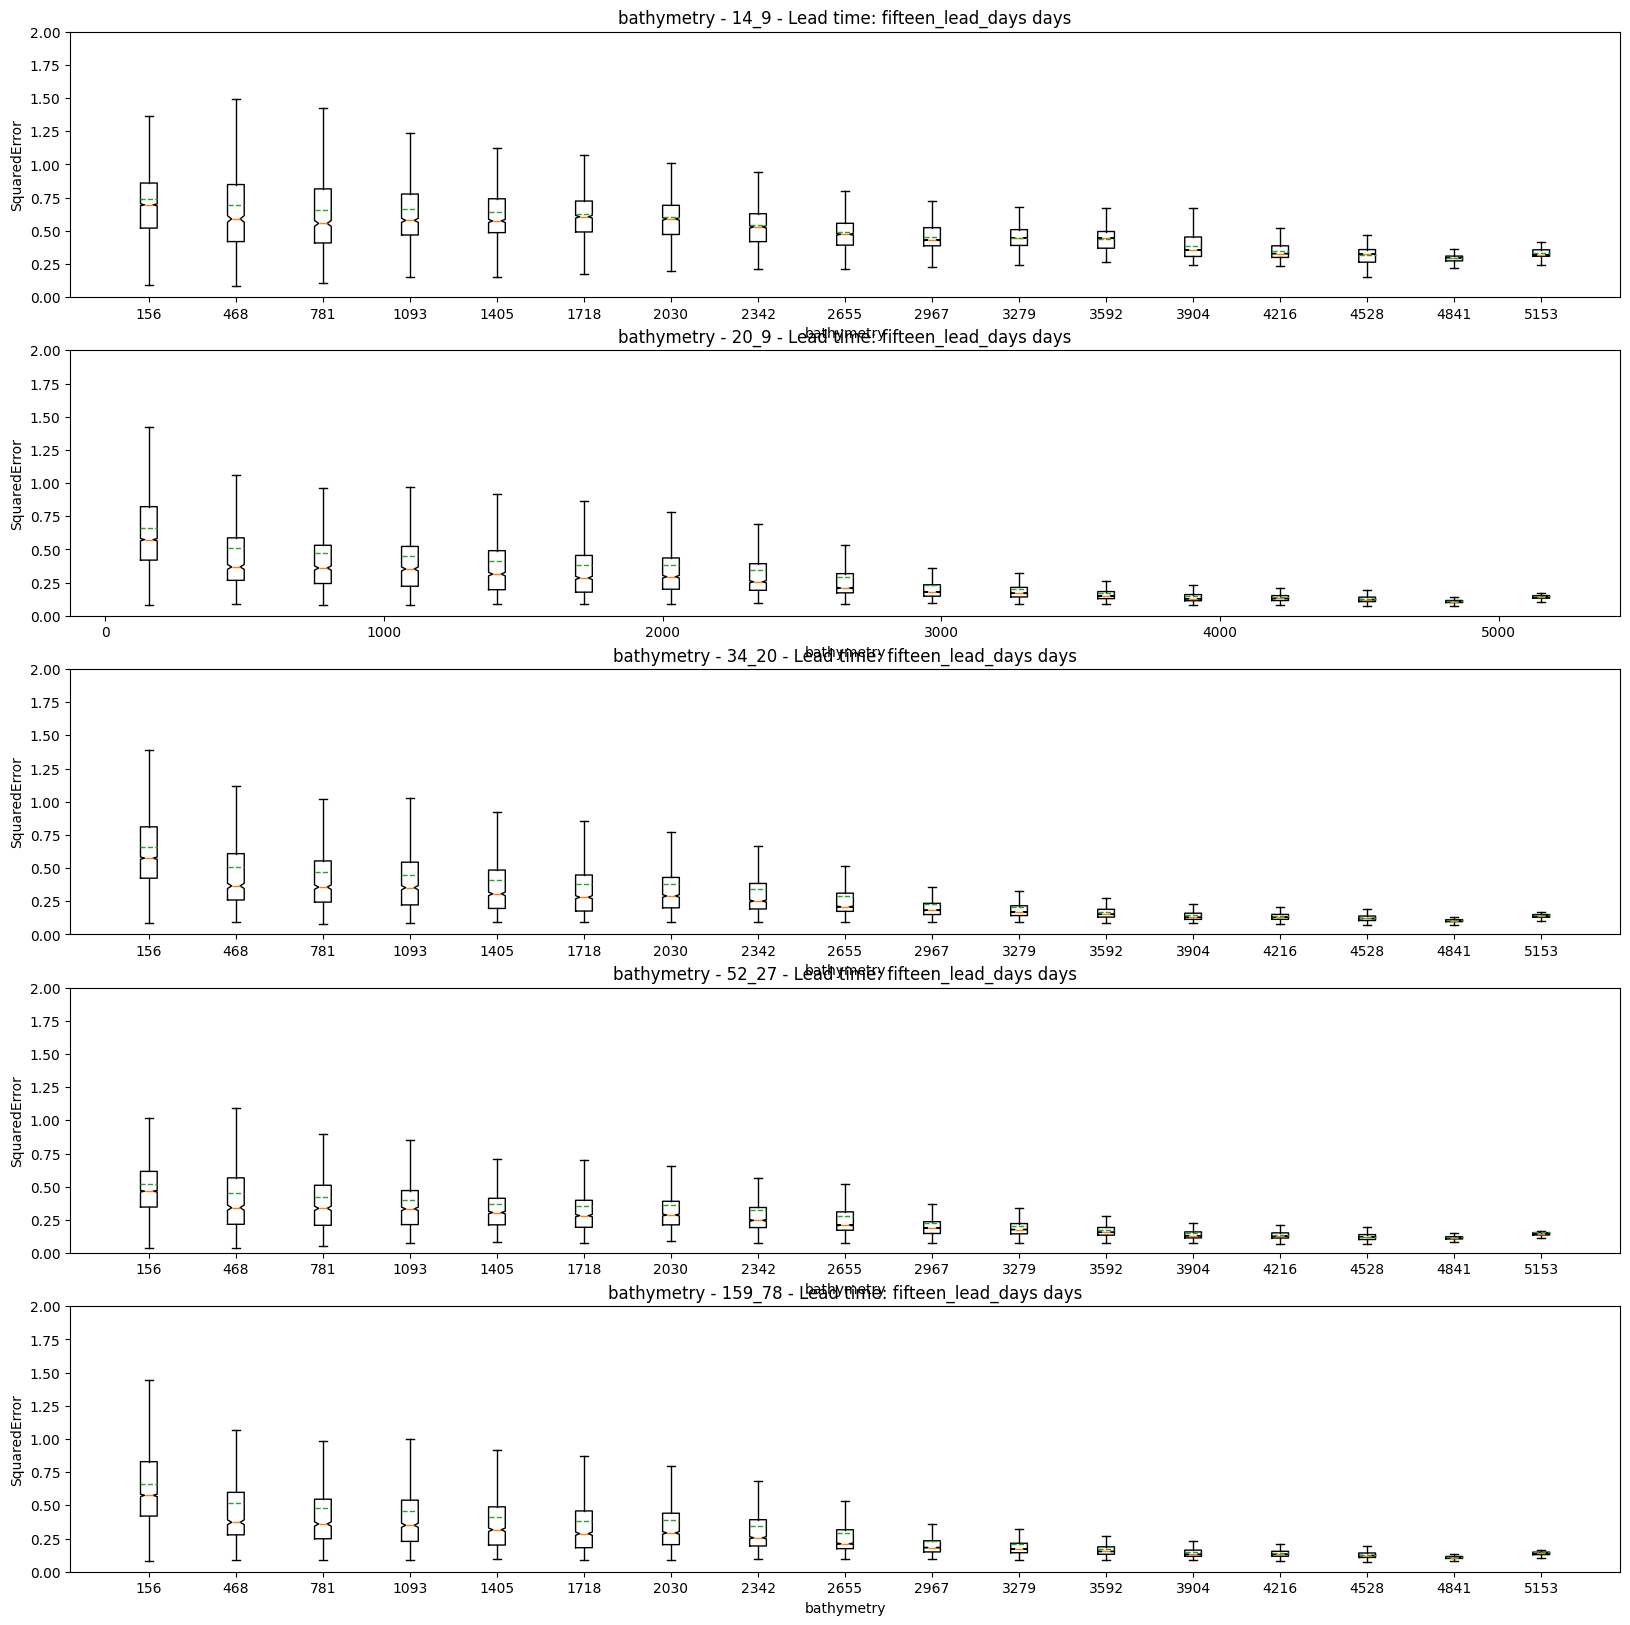

In [ ]:
from matplotlib.ticker import FormatStrFormatter

# Plot a specific score and variable for all experiments
score = TypeScore.RMSE.value
variable = TypeVariable.sst_temperature.value
n_nodes = NNodes.N14_9
lead_time = LeadTime.fifteen_lead_days
bin_type = 'linear'
# Plot each score and variable in the grid
fig, axs = plt.subplots(len(NNodes), 1, figsize=(20, 20))
for n, n_nodes in enumerate(NNodes):
    # Boxplot en las posiciones reales
    rmse_da = exp_dic[mesh][n_nodes][score][variable]
    rmse_binned = get_binned_rmse_by_array(rmse_da, bathy, bin_type=bin_type)
    # Posiciones reales en el eje logarítmico
    positions = [group.mid for group in rmse_binned.groups.keys()]
    axs[n].boxplot(
        [rmse_bin[1].sel(lead_time=lead_time.value).values for rmse_bin in rmse_binned], 
        positions=positions, 
        widths=np.array(positions)*0.11 if bin_type == 'log' else 60,
        showmeans=True, 
        meanline=True, 
        notch=True,
        showfliers=False,
    );
    axs[n].set_title(f'{mesh.value} - {n_nodes.value[0]} - Lead time: {lead_time.name} days');
    # Rotate x labels
    axs[n].set_xscale('log') if bin_type == 'log' else axs[1].set_xscale('linear')
    axs[n].set_ylabel(f'{score}');
    axs[n].set_xlabel('bathymetry');
    axs[n].xaxis.set_major_formatter(FormatStrFormatter('%.0f'));
    axs[n].set_ylim(0, 2);

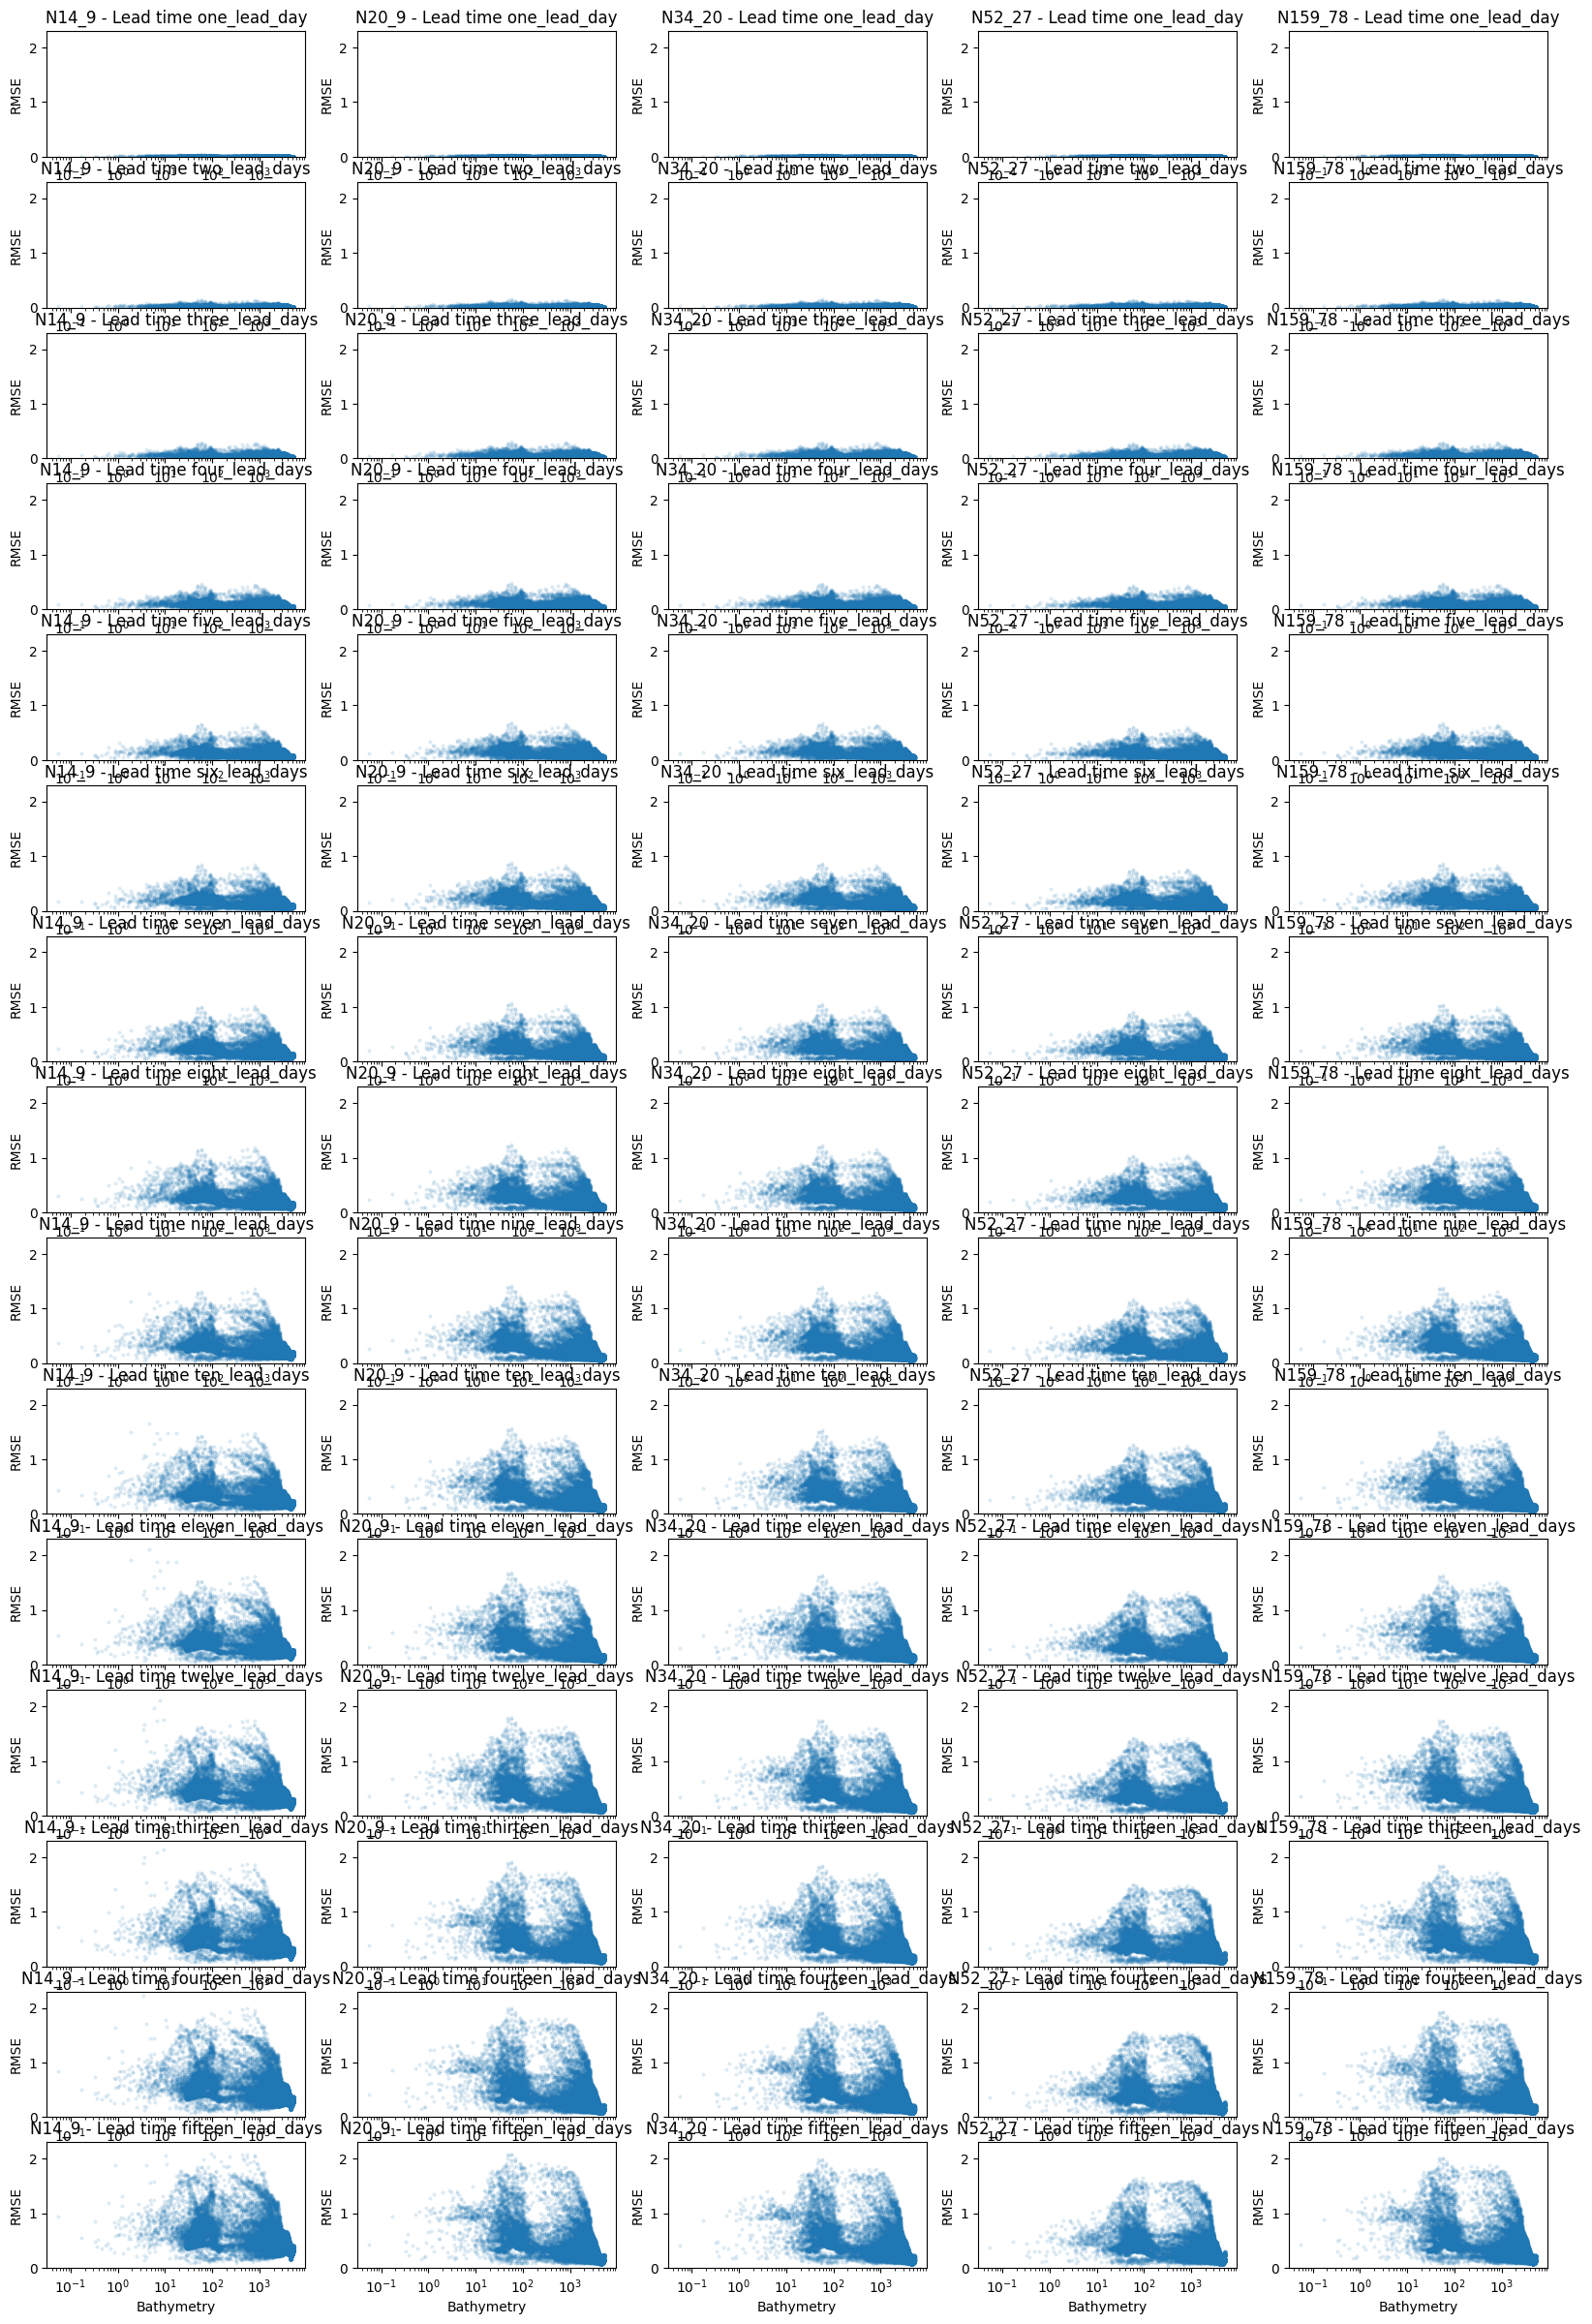

In [ ]:
score = TypeScore.RMSE.value
variable = TypeVariable.sst_temperature.value

fig, axs = plt.subplots(len(LeadTime), len(NNodes), figsize=(20, 30))

for n, n_nodes in enumerate(NNodes):
    for l, lead_time in enumerate(LeadTime):
        rmse_da = exp_dic[mesh][n_nodes][score][variable]
        rmse = rmse_da.sel(lead_time=lead_time.value).data
        axs[l, n].scatter(bathy.flatten(), rmse.flatten(), alpha=0.1, s=4)
        axs[l, n].set_xlabel('Bathymetry')
        axs[l, n].set_ylabel('RMSE')
        axs[l, n].set_ylim(0, 2.3)
        axs[l, n].set_xscale('log')
        axs[l, n].set_title(f'{n_nodes.name} - Lead time {lead_time.name}')

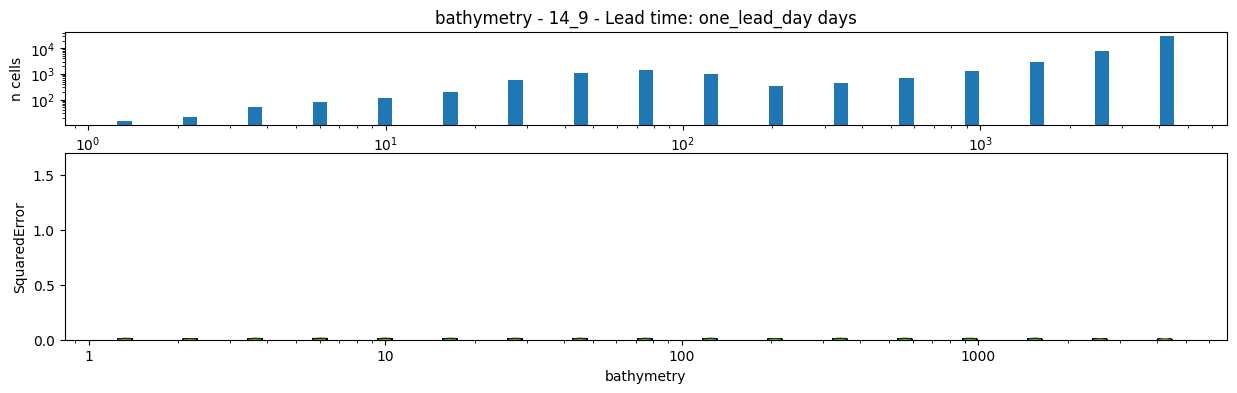

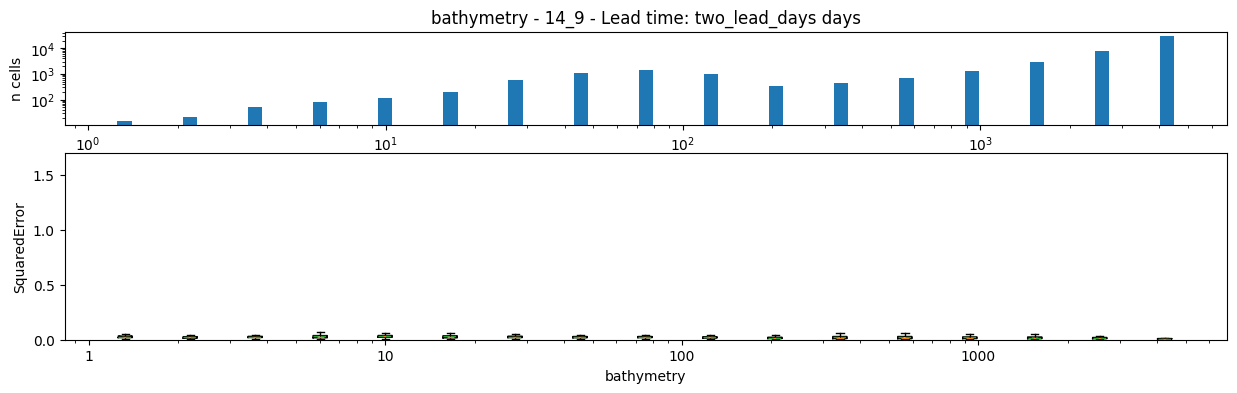

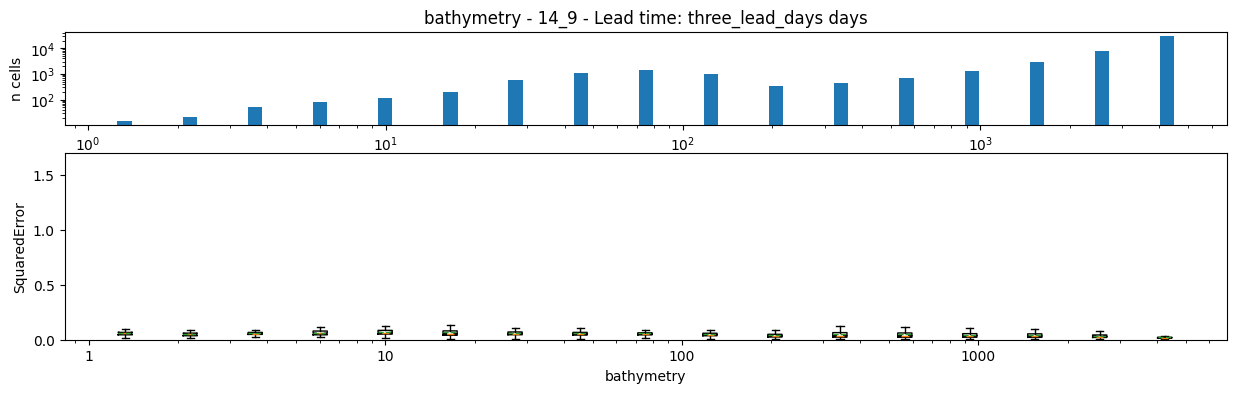

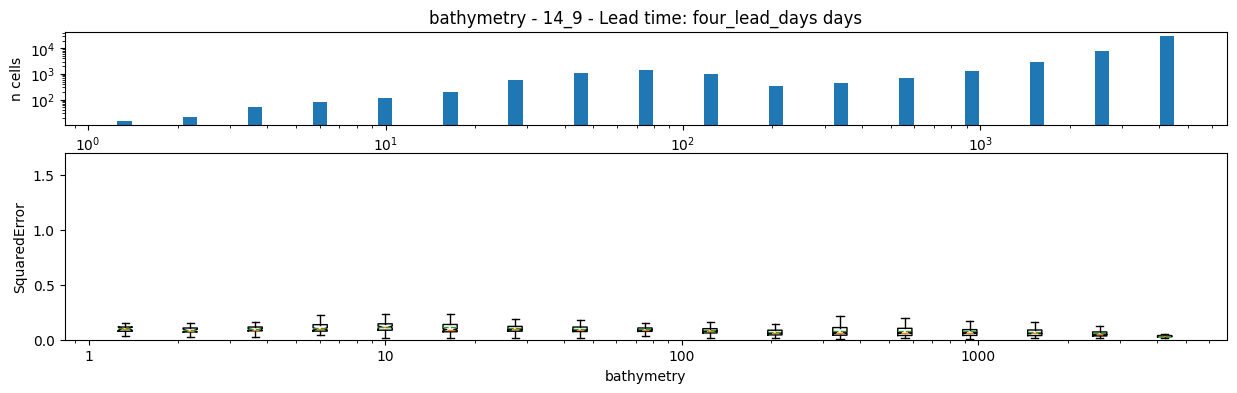

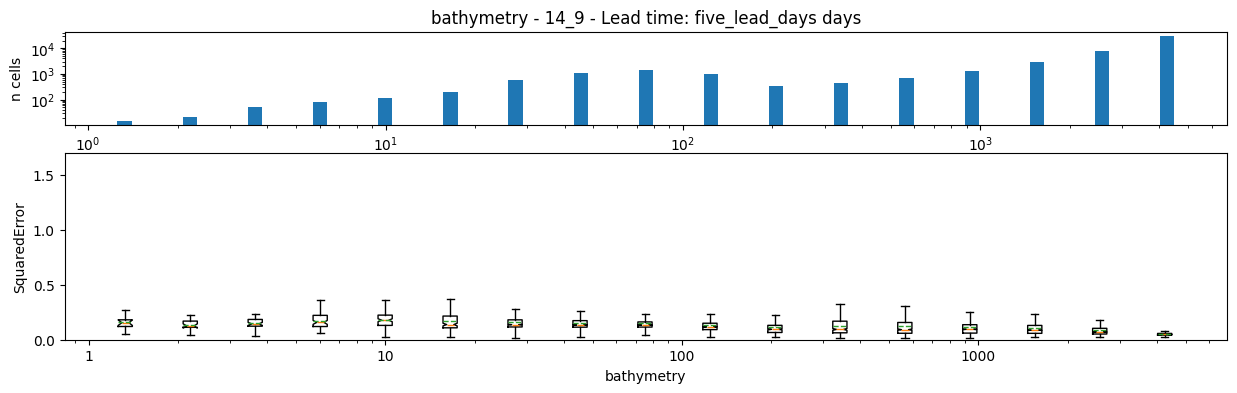

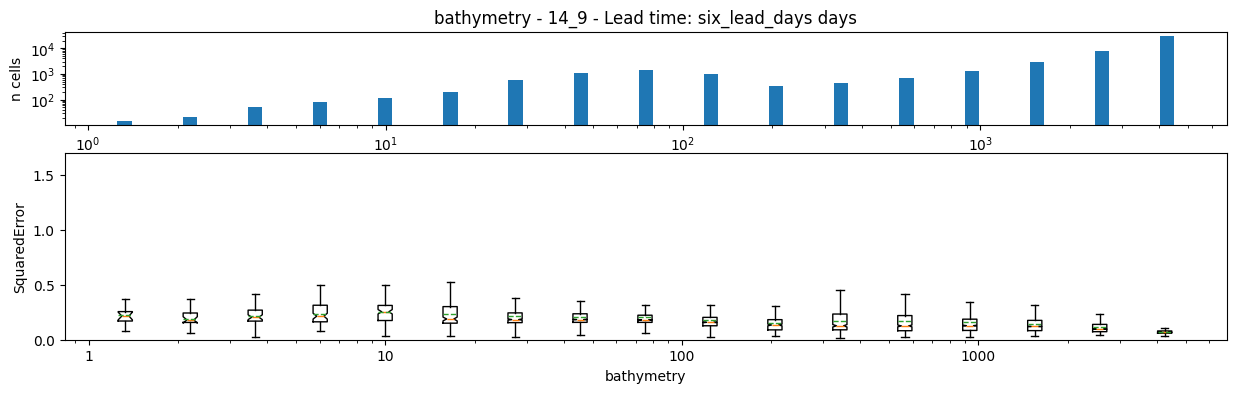

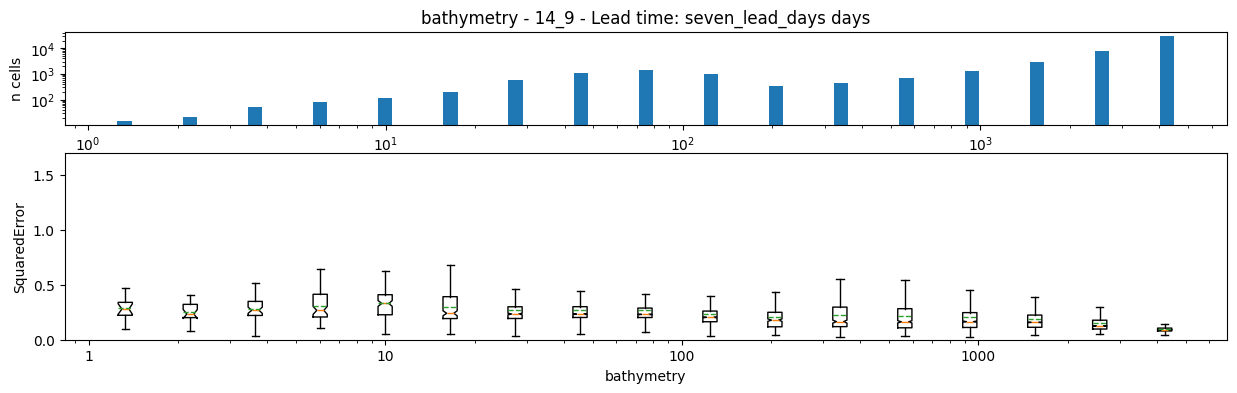

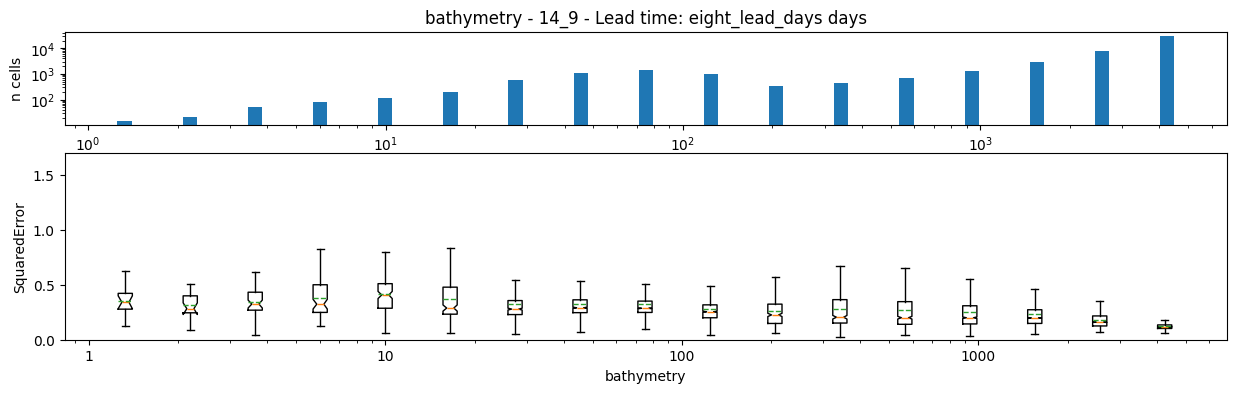

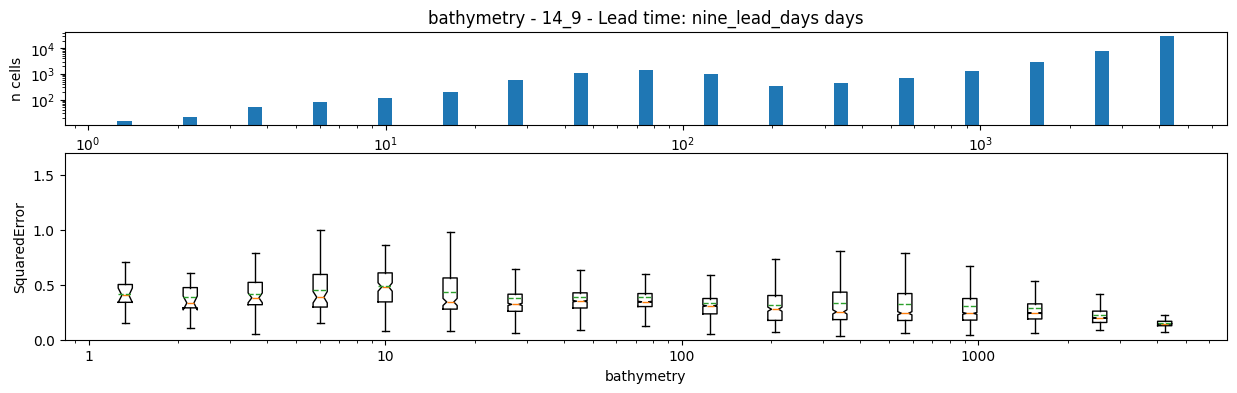

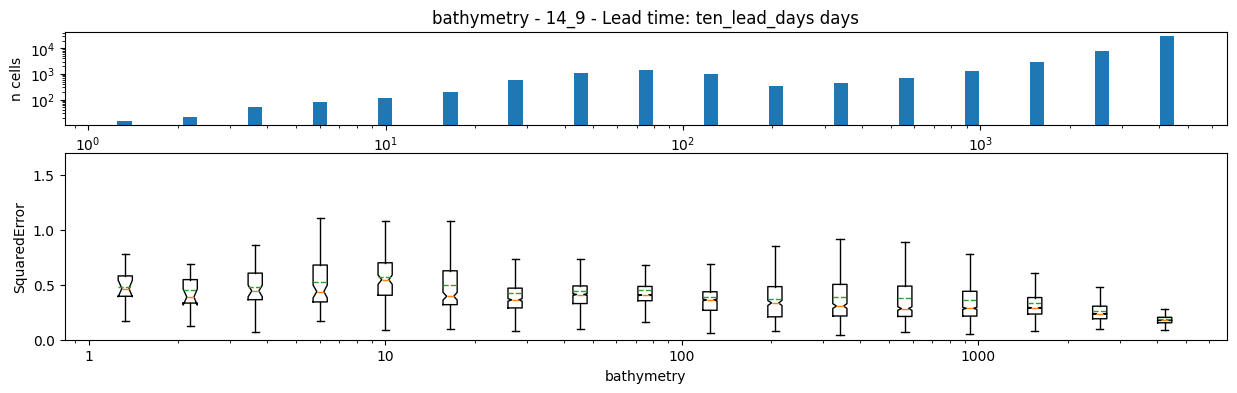

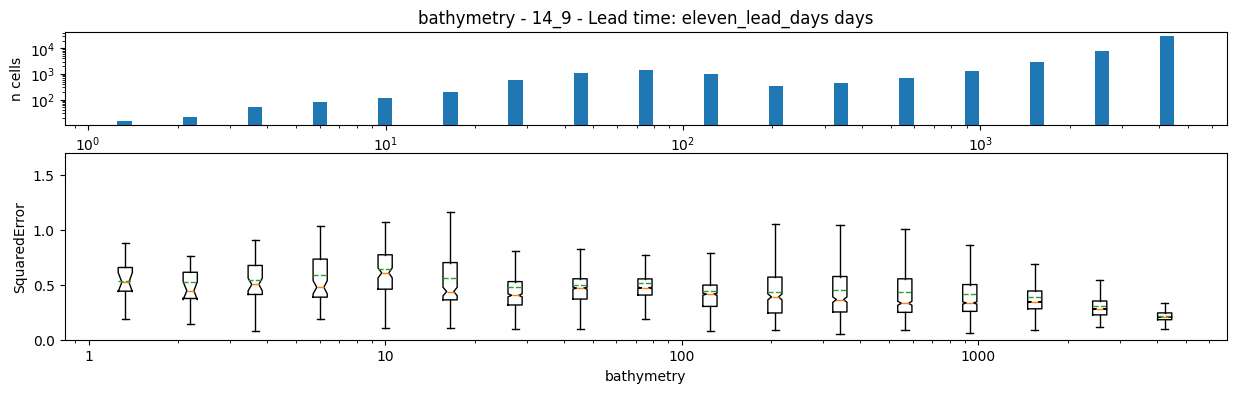

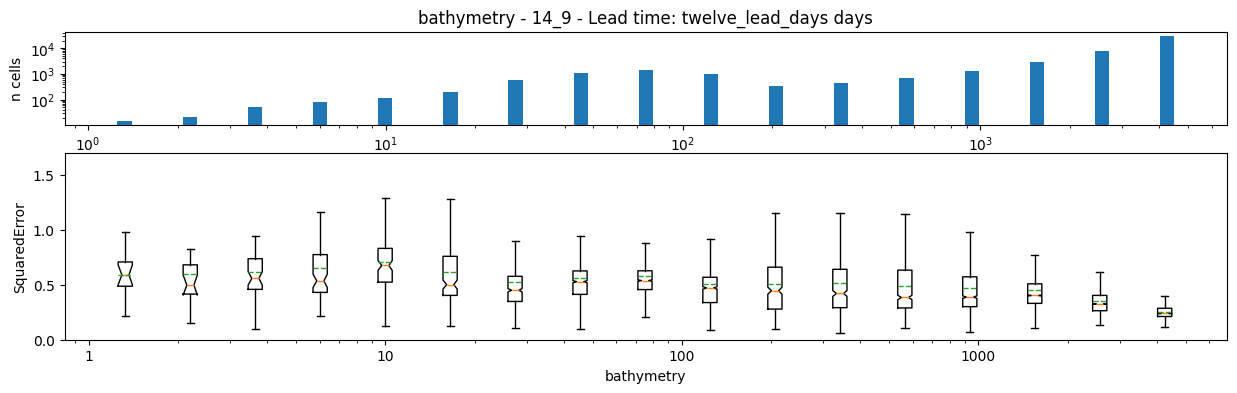

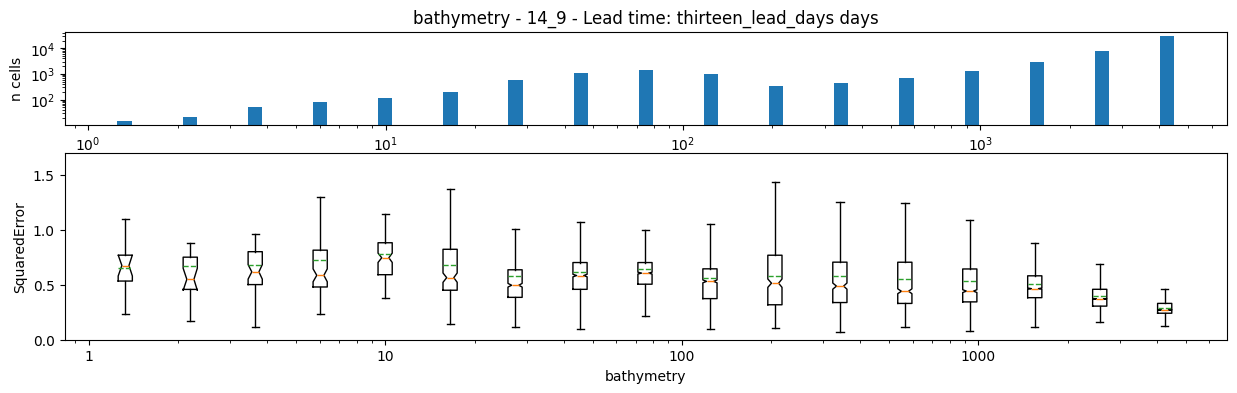

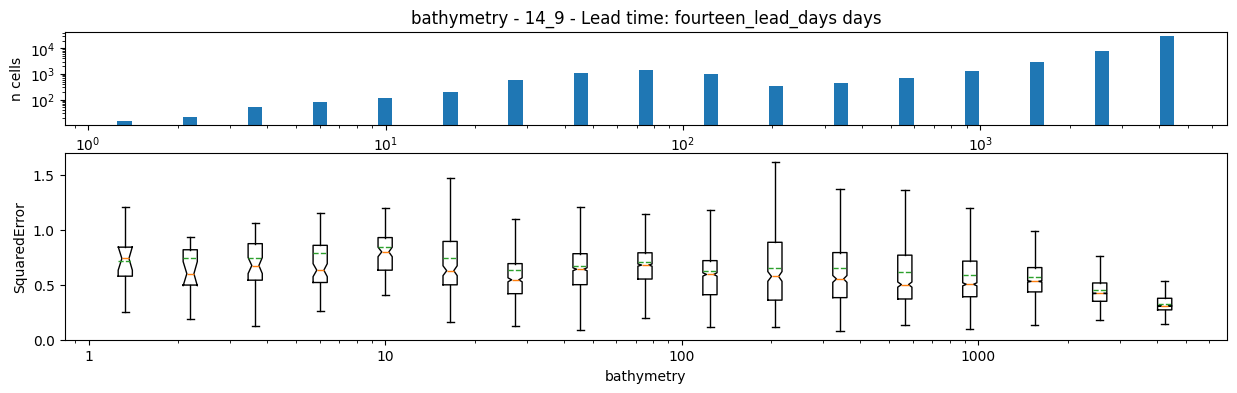

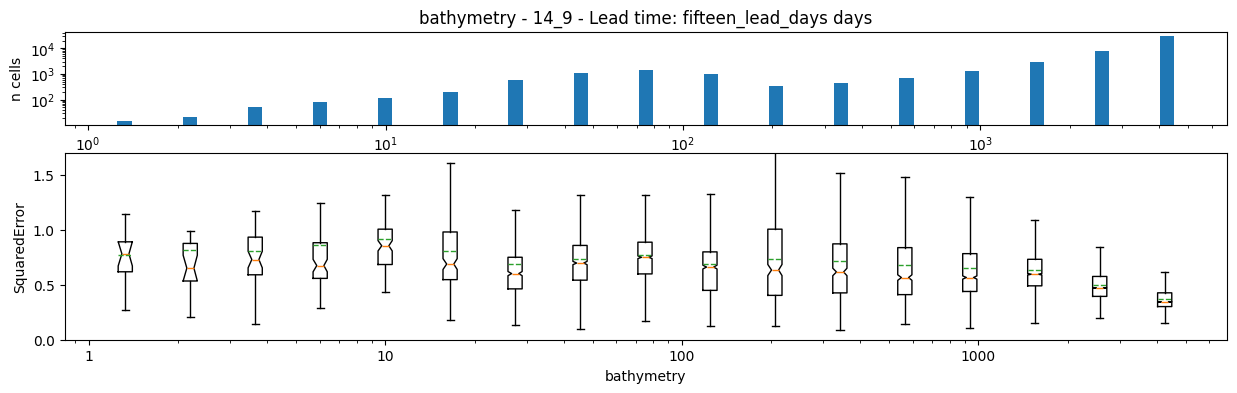

In [ ]:
from matplotlib.ticker import FormatStrFormatter

# Plot a specific score and variable for all experiments
score = TypeScore.RMSE.value
variable = TypeVariable.sst_temperature.value
n_nodes = NNodes.N14_9
rmse_da = exp_dic[mesh][n_nodes][score][variable]
bin_type = 'log'
rmse_binned = get_binned_rmse_by_array(rmse_da, bathy, bin_type=bin_type)
# Posiciones reales en el eje logarítmico
positions = [group.mid for group in rmse_binned.groups.keys()]
# Plot each score and variable in the grid
for lead_time in LeadTime:
    fig, axs = plt.subplots(2, 1, figsize=(15, 4), gridspec_kw={'height_ratios': [1, 2]})
    # Boxplot en las posiciones reales
    axs[0].bar(
        positions, 
        rmse_binned.count().sel(lead_time=lead_time.value).values, 
        width=np.array(positions)*0.11 if bin_type == 'log' else 60,
        )
    axs[0].loglog() if bin_type == 'log' else axs[0].set_yscale('log')
    axs[0].set_ylabel('n cells');
    axs[0].set_title(f'{mesh.value} - {n_nodes.value[0]} - Lead time: {lead_time.name} days');
    axs[1].boxplot(
        [rmse_bin[1].sel(lead_time=lead_time.value).values for rmse_bin in rmse_binned], 
        positions=positions, 
        widths=np.array(positions)*0.11 if bin_type == 'log' else 60,
        showmeans=True, 
        meanline=True, 
        notch=True,
        showfliers=False,
    );
    # Rotate x labels
    axs[1].set_xscale('log') if bin_type == 'log' else axs[1].set_xscale('linear')
    axs[1].set_ylabel(f'{score}');
    axs[1].set_xlabel('bathymetry');
    axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'));
    axs[1].set_ylim(0, 1.7);

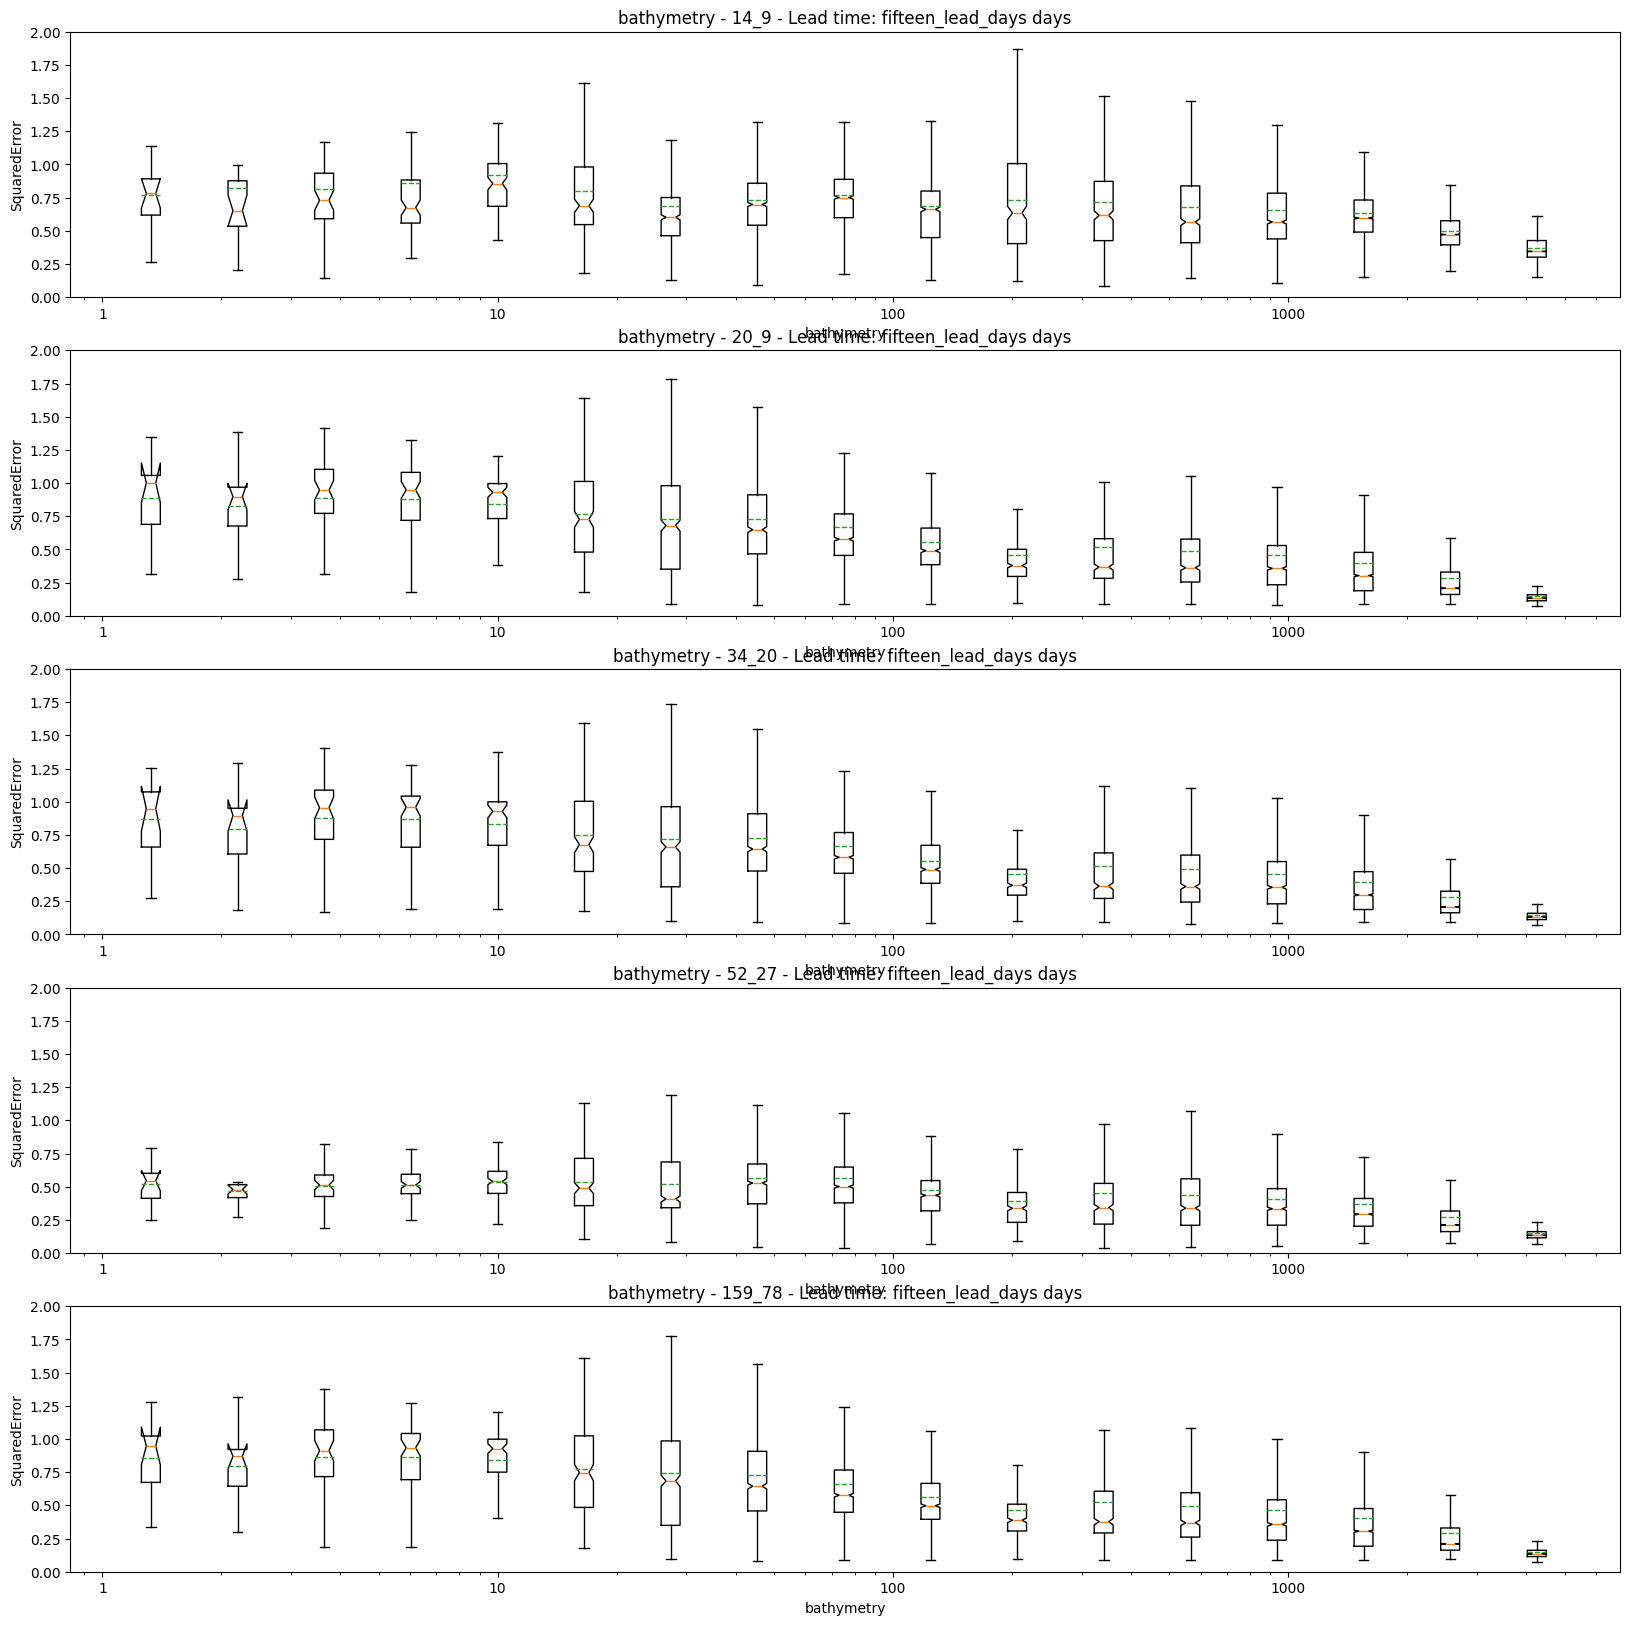

In [ ]:
from matplotlib.ticker import FormatStrFormatter

# Plot a specific score and variable for all experiments
score = TypeScore.RMSE.value
variable = TypeVariable.sst_temperature.value
n_nodes = NNodes.N14_9
lead_time = LeadTime.fifteen_lead_days
bin_type = 'log'
# Plot each score and variable in the grid
fig, axs = plt.subplots(len(NNodes), 1, figsize=(20, 20))
for n, n_nodes in enumerate(NNodes):
    # Boxplot en las posiciones reales
    rmse_da = exp_dic[mesh][n_nodes][score][variable]
    rmse_binned = get_binned_rmse_by_array(rmse_da, bathy, bin_type=bin_type)
    # Posiciones reales en el eje logarítmico
    positions = [group.mid for group in rmse_binned.groups.keys()]
    axs[n].boxplot(
        [rmse_bin[1].sel(lead_time=lead_time.value).values for rmse_bin in rmse_binned], 
        positions=positions, 
        widths=np.array(positions)*0.11 if bin_type == 'log' else 60,
        showmeans=True, 
        meanline=True, 
        notch=True,
        showfliers=False,
    );
    axs[n].set_title(f'{mesh.value} - {n_nodes.value[0]} - Lead time: {lead_time.name} days');
    # Rotate x labels
    axs[n].set_xscale('log') if bin_type == 'log' else axs[1].set_xscale('linear')
    axs[n].set_ylabel(f'{score}');
    axs[n].set_xlabel('bathymetry');
    axs[n].xaxis.set_major_formatter(FormatStrFormatter('%.0f'));
    axs[n].set_ylim(0, 2);